# LIBRERIA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial.distance import cdist

import importlib
import itertools
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

import sys
sys.path.append('../Scripts/')
import utilities_voronoi

import plotly.graph_objects as go

from utilities_voronoi import *
importlib.reload(utilities_voronoi)

<module 'utilities_voronoi' from 'c:\\Users\\apolo\\OneDrive - Universidad Pontificia Comillas\\Escritorio\\PhD\\Codigo\\NNMonotonic\\Notebooks\\../Scripts\\utilities_voronoi.py'>

# VORONOI SETS

## 2D VORONOI

### UNDERSTANDING VORONOI DIAGRAMS

##### USANDO PUNTOS SIMETRICOS

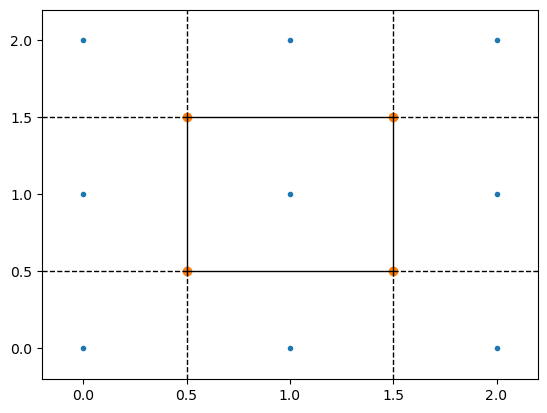

In [2]:
import numpy as np
points = np.array([[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2],
                   [2, 0], [2, 1], [2, 2]])
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(points)
import matplotlib.pyplot as plt
fig = voronoi_plot_2d(vor)
plt.show()

In [3]:
vor.ridge_points[:3]

array([[0, 3],
       [0, 1],
       [2, 5]], dtype=int32)

In [4]:
### GENERATE HYPERCUBE VERTICES
# Example usage:
n = 3  # Number of variables
intervals = [(0, 1), (0, 1), (0, 1)]  # Example intervals for each variable

vertices = utilities_voronoi.generate_hypercube_vertices(intervals)
for vertex in vertices:
    print(vertex)


[0 0 0]
[0 0 1]
[0 1 0]
[0 1 1]
[1 0 0]
[1 0 1]
[1 1 0]
[1 1 1]


In [5]:
#### EXTRACTION OF FACES OF THE HYPERCUBE
# Example usage:
intervals = [(0, 1), (0, 1), (0, 1)]
faces = utilities_voronoi.extract_hypercube_faces(vertices,intervals)
faces

{'x_00': array([[0, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 1]]),
 'x_01': array([[1, 0, 0],
        [1, 0, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 'x_10': array([[0, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 1]]),
 'x_11': array([[0, 1, 0],
        [0, 1, 1],
        [1, 1, 0],
        [1, 1, 1]]),
 'x_20': array([[0, 0, 0],
        [0, 1, 0],
        [1, 0, 0],
        [1, 1, 0]]),
 'x_21': array([[0, 0, 1],
        [0, 1, 1],
        [1, 0, 1],
        [1, 1, 1]])}

In [9]:
### EJEMPLO DE CALCULO (4 Dimensiones)
intervals = [(0, 1), (0, 1), (0, 1), (0, 1)]
vertices = utilities_voronoi.generate_hypercube_vertices(intervals)
faces = utilities_voronoi.extract_hypercube_faces(vertices,intervals)
faces['x_00']

array([[0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 1],
       [0, 1, 1, 0],
       [0, 1, 1, 1]])

**EXPLICACIÓN TEÓRICA: VECTOR NORMAL USANDO SVD**

Dada una matrix $A \in M_{m\times n}$ de rango k entonces existe una descomposición SVD que viene dada por:
$$ A = U \Sigma V^{T}$$ 
donde U y V están formadas por matrices de vectores ortonormales. Por lo tanto, si tomo un $v_i$ entonces se tiene que 
$$ A v_i = U\Sigma V^{T} v_i = U\Sigma e_i = \sigma_i u_i$$

Con lo cual dado que $\Sigma$ es una matriz de valores singulares, todos ellos positivos salvo los últimos n-k columnas que son nulos. Por lo tanto si $\sigma_i = 0$ entonces $v_i \in Ker(A)$ y de hecho generan el espacio del kernel. En el caso de un hiperplano, la dimensión del kernel es 1 luego solo existe un $v_i$ en esas condiciones

In [10]:
### EXTRACT NORMAL VECTOR TO A HYPERPLANE

###################################### NECESARIO REVISAR LA ORIENTACIÓN DEL VECTOR NORMAL (Producto escalar con el centroide del hipercubo)
""" Version Antigua
def utilities_voronoi.get_normal_vector(hyperplane_points):
    centroid = np.mean(hyperplane_points, axis=0)
    u, s, vh = np.linalg.svd(hyperplane_points - centroid, full_matrices=True)
    normal_vector = vh[-1]
    return normal_vector
"""

intervals = [(0, 1), (0, 1), (0, 1)]
vertices = utilities_voronoi.generate_hypercube_vertices(intervals)
faces = utilities_voronoi.extract_hypercube_faces(vertices,intervals)
centroid_hypercube = np.mean(vertices, axis=0)
print('The normal vector to the hyperplane x_00 is {}',utilities_voronoi.get_normal_vector(faces['x_00'],centroid_hypercube))
print(faces['x_00'])
print('The normal vector to the hyperplane x_20 is {}',utilities_voronoi.get_normal_vector(faces['x_20'],centroid_hypercube))
print(faces['x_20'])

The normal vector to the hyperplane x_00 is {} [-1.  0.  0.]
[[0 0 0]
 [0 0 1]
 [0 1 0]
 [0 1 1]]
The normal vector to the hyperplane x_20 is {} [-0. -0. -1.]
[[0 0 0]
 [0 1 0]
 [1 0 0]
 [1 1 0]]


In [11]:
############## CASO PARTICULAR -> 2 DIMENSIONES
# Create a function to calculate symmetric points for a given point and square
def calculate_symmetric_points(point, square_vertices):
    symmetric_points = []
    for i in range(4):  # Iterate through the four sides of the square
        p1 = square_vertices[i]
        p2 = square_vertices[i + 1]
        side_vector = p2 - p1
        normalized_side_vector = side_vector / np.linalg.norm(side_vector)
        point_vector = point - p1
        distance = np.dot(point_vector, normalized_side_vector)
        symmetric_point = point - 2 * distance * normalized_side_vector
        symmetric_points.append(symmetric_point)
    return symmetric_points

############## CASO PARTICULAR -> 3 DIMENSIONES
# Create a function to calculate symmetric points for a given point and cube
def calculate_symmetric_points_cube(point, cube_vertices):
    symmetric_points = []
    for i in range(6):  # Iterate through the six faces of the cube
        face_vertices = cube_vertices[i]
        for j in range(4):  # Iterate through the four edges of each face
            p1 = face_vertices[j]
            p2 = face_vertices[(j + 1) % 4]  # Wrap around for the last edge
            edge_vector = p2 - p1
            normalized_edge_vector = edge_vector / np.linalg.norm(edge_vector)
            point_vector = point - p1
            distance = np.dot(point_vector, normalized_edge_vector)
            symmetric_point = point - 2 * distance * normalized_edge_vector
            symmetric_points.append(symmetric_point)
    return symmetric_points

In [12]:
######################## GENERALIZACIÓN A N DIMENSIONES ############################
## Referencia 1) https://demo.webassign.net/ebooks/worldwidecmmvcalc1demo/pdf/1-3.pdf (Introducción a la proyeccion ortogonal)
# 2)http://www.sunshine2k.de/articles/coding/vectorreflection/vectorreflection.html (Reflexión de un vector)
# 3) https://stackoverflow.com/questions/5454661/reflection-how-do-i-do-it#:~:text=The%20formula%20for%20reflection%20is,operation%20of%20%22dot%20product%22.&text=The%20dot%20product%20between%20a,by%20the%20length%20of%20b. (Explicacion sencilla)
# 4) https://math.stackexchange.com/questions/1165019/how-do-dot-product-reflections-work (Este lo explica muy bien)
""" Version Antigua
def calculate_symmetric_points(point, hyperrectangle_vertices):
    ## Initialization of of the list of symmetric points
    symmetric_points = []
    ## Check if firts point of the hyperrectangle is added to the end of the list to close the polygon
    if not np.array_equal(hyperrectangle_vertices[0], hyperrectangle_vertices[-1]):
        ## The firts point of the hyperrectangle is added to the end of the list to close the polygon
        hyperrectangle_vertices = np.concatenate((hyperrectangle_vertices, [hyperrectangle_vertices[0]]), axis=0)

    ## Number of sides of the hyperrectangles
    num_sides = len(hyperrectangle_vertices)-1
    ## Iteration through the sides of the hyperrectangle    
    for i in range(num_sides):
        ## The first and second points of the side are taken
        p1 = hyperrectangle_vertices[i]
        p2 = hyperrectangle_vertices[i + 1]
        ## The vector that represents the side is calculated
        side_vector = p2 - p1
        ## The normalized vector is calculated
        normalized_side_vector = side_vector / np.linalg.norm(side_vector)
        ## The vector that goes from the first point of the side to the point is calculated
        point_vector = point - p1
        ## The symmetric point is calculated (Given a vector n, the symmetric vector is given by: v-2*(v.n)*n)
        symmetric_point = point - 2 * np.dot(point_vector, normalized_side_vector) * normalized_side_vector
        symmetric_points.append(symmetric_point)
    
    return symmetric_points
"""




' Version Antigua\ndef calculate_symmetric_points(point, hyperrectangle_vertices):\n    ## Initialization of of the list of symmetric points\n    symmetric_points = []\n    ## Check if firts point of the hyperrectangle is added to the end of the list to close the polygon\n    if not np.array_equal(hyperrectangle_vertices[0], hyperrectangle_vertices[-1]):\n        ## The firts point of the hyperrectangle is added to the end of the list to close the polygon\n        hyperrectangle_vertices = np.concatenate((hyperrectangle_vertices, [hyperrectangle_vertices[0]]), axis=0)\n\n    ## Number of sides of the hyperrectangles\n    num_sides = len(hyperrectangle_vertices)-1\n    ## Iteration through the sides of the hyperrectangle    \n    for i in range(num_sides):\n        ## The first and second points of the side are taken\n        p1 = hyperrectangle_vertices[i]\n        p2 = hyperrectangle_vertices[i + 1]\n        ## The vector that represents the side is calculated\n        side_vector = p

**EXPLICACIÓN: PUNTOS SIMÉTRICOS**

El concepto fundamental parte del producto escalar de dos vectores. Dados a,b, entonces se tiene que el dot product $a ∙ b$ corresponde al resultado de proyectar b sobre a dividido por la longitud del vector a $|p_b| = (a ∙ b / |a|)$. En concreto,si normalizamos a y consideramos $a_n$ se tiene que $|p_b| = (a ∙ b)$. 

![Logo de Markdown](../Figures/dotproduct2.png)

Por lo tanto, descomponiendo el vector b en su componente paralela $b_{par}$ y su componente perpendicular $b_{per}$ entonces se tiene que $b = b_{par}+b_{per}$. Además por el mismo principio de antes, el dot product es la proyección, claramente se tiene que $ b_{par} = (a_n ∙ b) * a_n$

![Logo de Markdown](../Figures/dotproduct3.png)

Para encontrar la componente perpendicular, puedo hacer uso del vector normal unitario. En este caso, en vez de usar $a_n$ voy a utilizar $n$ y por el mismo principio se tiene que $ b_{per} = (n ∙ b) * n$. Para encontrar la reflexión del punto, solo hace falta ver la imagen siguiente para darse cuenta que para llegar a r es necesario recorrer a y recorrer dos veces $b_{per}$ con sentido opuesto. Por lo tanto:
$$r = a - 2 (n ∙ b) * n$$

![Logo de Markdown](../Figures/C7ea5.png)


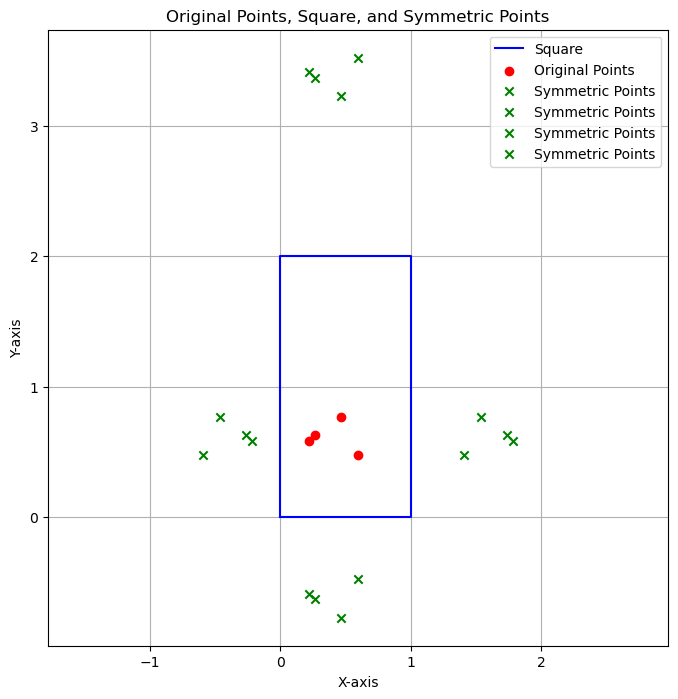

In [13]:
######## EJEMPLO -> CALCULO DaE PUNTOS SIMÉTRICOS DE UN CUADRADO ######## ANTIGUO
# Define the coordinates of the square's vertices
square_vertices = np.array([[0, 0], [0, 2], [1, 2], [1, 0],[0,0]])
#np.random.seed(1234)
points = np.random.rand(4, 2)

# Calculate symmetric points for each point
symmetric_points_list = [calculate_symmetric_points(point, square_vertices) for point in points]

# Plotting
plt.figure(figsize=(8, 8))

# Plot the square
square_x, square_y = square_vertices[:, 0], square_vertices[:, 1]
plt.plot(square_x, square_y, 'b-', label='Square')

# Plot the original points
original_x, original_y = points[:, 0], points[:, 1]
plt.scatter(original_x, original_y, color='red', marker='o', label='Original Points')

# Plot the symmetric points
for symmetric_points in symmetric_points_list:
    symmetric_x, symmetric_y = np.array(symmetric_points)[:, 0], np.array(symmetric_points)[:, 1]
    plt.scatter(symmetric_x, symmetric_y, color='green', marker='x', label='Symmetric Points')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.title('Original Points, Square, and Symmetric Points')
plt.axis('equal')
plt.show()


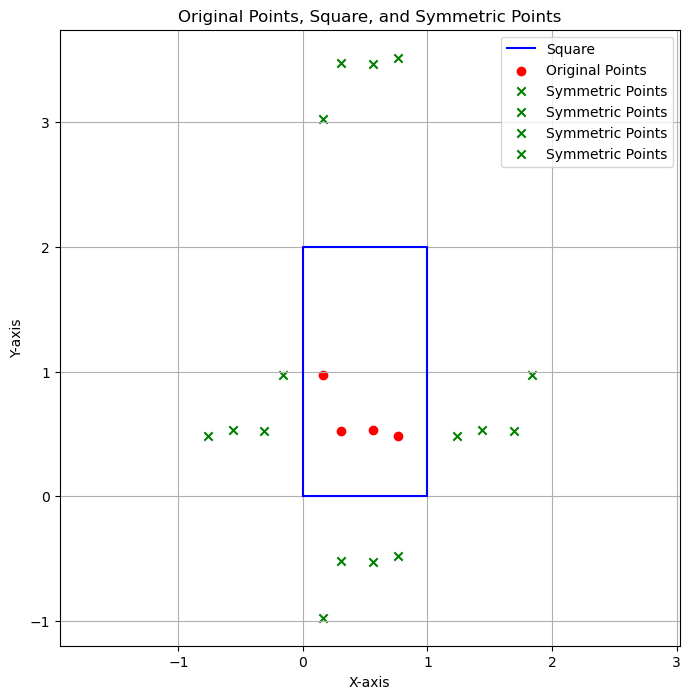

In [14]:
######## EJEMPLO -> CALCULO DE PUNTOS SIMÉTRICOS DE UN CUADRADO ########
#np.random.seed(1234)

# Define the coordinates of the square's vertices
intervals = [(0, 1), (0, 2)]
vertices = utilities_voronoi.generate_hypercube_vertices(intervals)
faces = utilities_voronoi.extract_hypercube_faces(vertices,intervals)
square = np.array([[0, 0], [0, 2], [1, 2], [1, 0],[0,0]])

## Escogemos cuatro puntos aleatorios dentro del cuadrado [0,1]x[0,2]
points= np.random.rand(4, 2)
points[:,1] = points[:,1]*1.5
# Calculate symmetric points for each point
symmetric_points_list = [utilities_voronoi.calculate_symmetric_points_faces(point, faces) for point in points]

# Plotting
plt.figure(figsize=(8, 8))

# Plot the square
square_x, square_y = square[:, 0], square[:, 1]
plt.plot(square_x, square_y, 'b-', label='Square')

# Plot the original points
original_x, original_y = points[:, 0], points[:, 1]
plt.scatter(original_x, original_y, color='red', marker='o', label='Original Points')

# Plot the symmetric points
for symmetric_points in symmetric_points_list:
    symmetric_x, symmetric_y = np.array(symmetric_points)[:, 0], np.array(symmetric_points)[:, 1]
    plt.scatter(symmetric_x, symmetric_y, color='green', marker='x', label='Symmetric Points')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.title('Original Points, Square, and Symmetric Points')
plt.axis('equal')
plt.show()

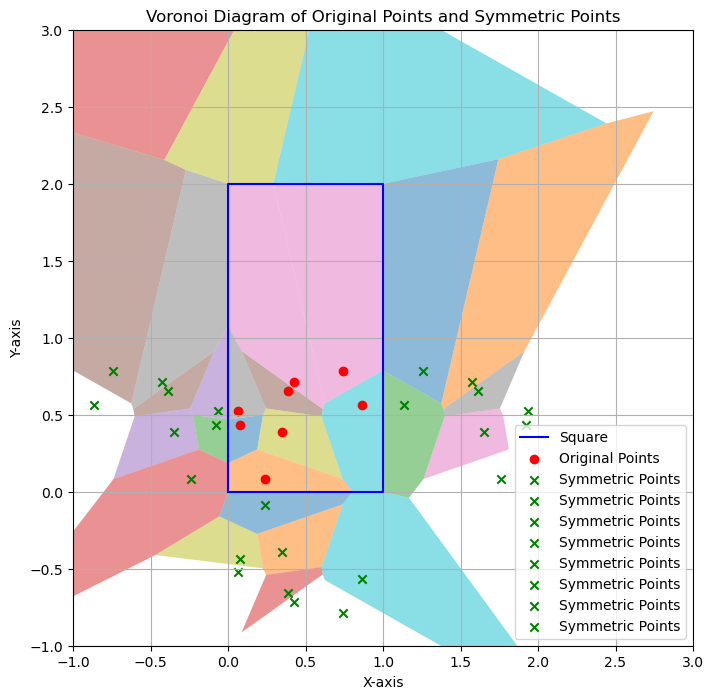

In [15]:
# Calculate symmetric points for each point
#np.random.seed(1234)
points = np.random.rand(8, 2)
symmetric_points_list = [utilities_voronoi.calculate_symmetric_points_faces(point, faces) for point in points]

# Combine original and symmetric points
all_points = np.vstack((points, np.array(symmetric_points_list).reshape(-1, 2)))

# Compute Voronoi diagram
vor = Voronoi(all_points)

# Plot Voronoi diagram
plt.figure(figsize=(8, 8))

# Plot Voronoi regions
for region in vor.regions:
    if -1 not in region and len(region) > 0:
        polygon = [vor.vertices[i] for i in region]
        plt.fill(*zip(*polygon), alpha=0.5)

# Plot the square
square_x, square_y = square[:, 0], square[:, 1]
plt.plot(square_x, square_y, 'b-', label='Square')

# Plot the original points
original_x, original_y = points[:, 0], points[:, 1]
plt.scatter(original_x, original_y, color='red', marker='o', label='Original Points')

# Plot the symmetric points
for symmetric_points in symmetric_points_list:
    symmetric_x, symmetric_y = np.array(symmetric_points)[:, 0], np.array(symmetric_points)[:, 1]
    plt.scatter(symmetric_x, symmetric_y, color='green', marker='x', label='Symmetric Points')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim([-1, 3])
plt.ylim([-1, 3])
plt.legend()
plt.grid(True)
plt.title('Voronoi Diagram of Original Points and Symmetric Points')
#plt.axis('equal')
plt.show()


In [16]:
### GENERATE  FUNCTION TO DEFINE IF A N-DIM POINT IS INSIDE A HYPERCUBE (Function to replace contains of Shapely)
#################### REPASAR ESTA FUNCIÓN
## Example
intervals = [(0, 1), (0, 1), (0, 1)]
vertices = utilities_voronoi.generate_hypercube_vertices(intervals)
utilities_voronoi.is_inside_hypercube(np.array([0.5,0.5,0.5]),vertices)

True

In [17]:
### GENERATE  FUNCTION TO DEFINE IF A N-DIM POINT IS INSIDE A HYPERCUBE (Function to replace contains of Shapely)
def add_symmetric_points(vor,vertices,intervals):

    ## Extract faces of the hypercube
    faces = utilities_voronoi.extract_hypercube_faces(vertices,intervals)
    ## Lista para almacenar los puntos simétricos
    symmetric_points_list = []
    ## Iteramos en las regiones del voronoi
    for i, r in enumerate(vor.point_region):
        ## Extraemos la región para el punto i-ésimo
        region = vor.regions[r]
        
        ## Si la región contiene un -1 se añaden puntos simétricos
        if -1 in region:
            symmetric_points = utilities_voronoi.calculate_symmetric_points_faces(vor.points[i], faces)
            symmetric_points_list.append(symmetric_points)
        ### Si además el punto más alejado de la región del voronoi está fuera del cuadrado se añaden puntos simétricos
        else:
            region_vertices = vor.vertices[region]
            furthest_vertex = region_vertices[np.argmax(np.linalg.norm(region_vertices - vor.points[i], axis=1))]
            #if not Polygon(square_vertices).contains(Point(furthest_vertex)): ########### REEMPLAZAR POR LA NUEVA FUNCION
            if not utilities_voronoi.is_inside_hypercube(furthest_vertex,vertices):
                symmetric_points = utilities_voronoi.calculate_symmetric_points_faces(vor.points[i], faces)
                symmetric_points_list.append(symmetric_points)

    ## Combine original and symmetric points
    all_points = np.vstack((vor.points, np.array(symmetric_points_list).reshape(-1, vertices.shape[1]))) ### GENERALIZAR PARA N DMIENSIONES
    return all_points

## Generate Function to check if the space is filled based on the distance to the furthes vertex and the radius
def check_space_filled(vor,radius,vertices,all_points): 
    distances = dict()
    # Find furthest vertices for each point
    for i,point in enumerate(vor.points):
        ## Extract the region index for the point i
        region_idx = vor.point_region[i]
        ## Check if the furthest vertex is inside the boundary polygon
        if utilities_voronoi.is_inside_hypercube(point,vertices): ##### REVISAR QUE ESTA CONDICIÓN SEA CORRECTA
            ## Extract the vertices of the region
            region_vertices = vor.vertices[vor.regions[region_idx]]
            ## Extract the furthest vertex
            furthest_vertex = region_vertices[np.argmax(np.linalg.norm(region_vertices - all_points[i], axis=1))]
            ## Compute distance to furthest vertex
            distance = np.linalg.norm(point-furthest_vertex)
            distances['{}'.format(all_points[i])] = distance
    ## Check if the space is filled
    if np.all(np.array(np.array(list(distances.values())))<=radius):
        return True ,distances
    else:
        return False ,distances
 


In [18]:
# Sample set of points (replace with your own)
original_points = np.random.rand(8, 3)
## Generate vertices for a hypercube (n-dimensional cube) defined by the given interval
intervals = [(0, 1), (0, 1),(0,1)]
vertices = utilities_voronoi.generate_hypercube_vertices(intervals)
vertices

array([[0, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 1],
       [1, 0, 0],
       [1, 0, 1],
       [1, 1, 0],
       [1, 1, 1]])

In [20]:
##### PLOT VORONOI WITH FURTHEST POINTS #####
np.random.seed(2023)

# Sample set of points (replace with your own)
original_points = np.random.rand(4, 3)
## Generate vertices for a hypercube (n-dimensional cube) defined by the given interval
intervals = [(0, 1), (0, 1),(0,1)]
vertices = utilities_voronoi.generate_hypercube_vertices(intervals)
## Define the coordinates of the square's vertices
#square_vertices = np.array([[0, 0], [0, 1], [1, 1], [1, 0],[0,0]]) NECCESARY?

## Compute original Voronoi diagram
vor = Voronoi(original_points)

## Compute symmetric points
all_points = add_symmetric_points(vor,vertices,intervals)

## Compute Voronoi diagram
vor = Voronoi(all_points)

## Generate random radios for the points
radios = np.random.rand(len(original_points))/3 +0.1

## Generate random 1 or -1 as the sign
derivative_sign = np.random.choice([-1,1],len(original_points))

## Plot Voronoi diagram
utilities_voronoi.plot_finite_voronoi_3D(vor,all_points,original_points,plot_symmetric_points=False)

## Check if the space is filled
space_filled,distances = utilities_voronoi.check_space_filled(vor,radios,vertices)
print(space_filled)

False


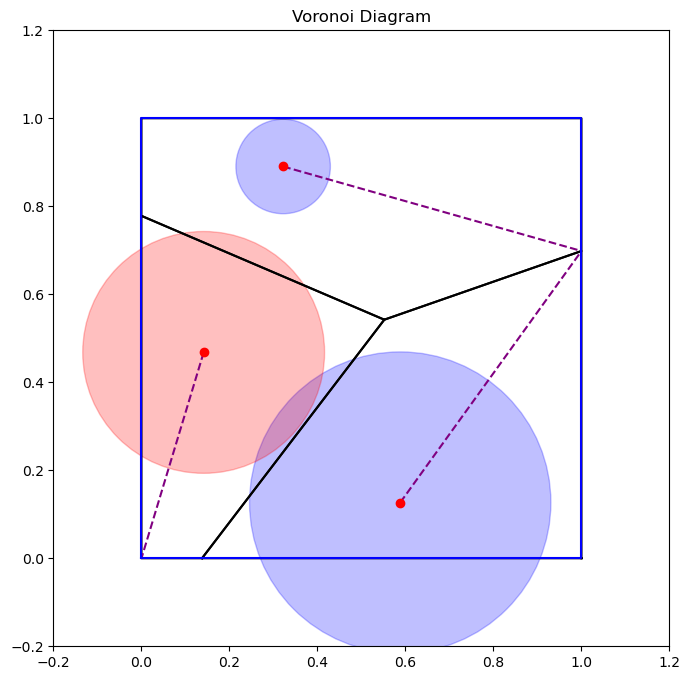

False


In [17]:
##### PLOT VORONOI WITH FURTHEST POINTS #####
np.random.seed(2023)

# Sample set of points (replace with your own)
original_points = np.random.rand(3, 2)
## Generate vertices for a hypercube (n-dimensional cube) defined by the given interval
intervals = [(0, 1), (0, 1)]
vertices = utilities_voronoi.generate_hypercube_vertices(intervals)
## Define the coordinates of the square's vertices
square_vertices = np.array([[0, 0], [0, 1], [1, 1], [1, 0],[0,0]])

## Compute original Voronoi diagram
vor = Voronoi(original_points)

## Compute symmetric points
all_points = add_symmetric_points(vor,vertices,intervals)

## Compute Voronoi diagram
vor = Voronoi(all_points)

## Generate random radios for the points
radios = np.random.rand(len(original_points))/3 +0.1

## Generate random 1 or -1 as the sign
derivative_sign = np.random.choice([-1,1],len(original_points))

## Plot Voronoi diagram
utilities_voronoi.plot_finite_voronoi_2D(vor,all_points,original_points,radios,square_vertices,derivative_sign=derivative_sign,plot_symmetric_points=False)

## Check if the space is filled
space_filled,distances = check_space_filled(vor,radios,vertices,all_points)
print(space_filled)


[0.74606341 0.83100699]
[0.63372577 0.43830988]
[0.15257277 0.56840962]
[0.52822428 0.95142876]
[0.05711564 0.66942174]
[0.76711663 0.70811536]


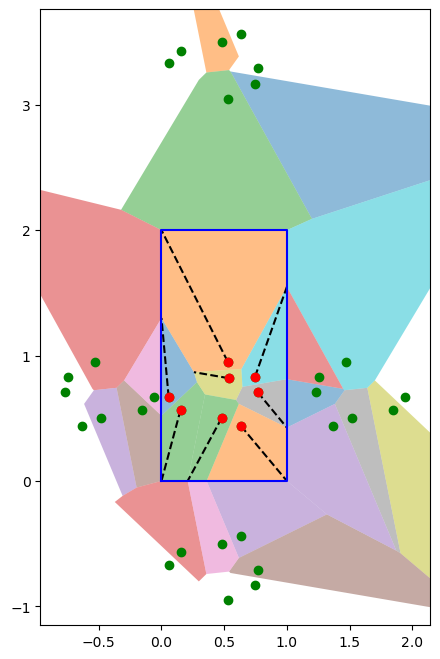

In [155]:
##### PLOT VORONOI WITH FURTHEST POINTS ##### ANTIGUO
#np.random.seed(1234)
# Sample set of points (replace with your own)
original_points = np.random.rand(8, 2)
## Generamos los vertices del cuadrado que será la boundary polygon
square_vertices = np.array([[0, 0], [0, 2], [1, 2], [1, 0],[0,0]])
## Lista para almacenar los puntos simétricos
symmetric_points_list = []
## Calculamos el voronoi original
vor = Voronoi(original_points)
## Iteramos en las regiones del voronoi
for i, r in enumerate(vor.point_region):
    ## Extraemos la región para el punto i-ésimo
    region = vor.regions[r]
    
    ## Si la región contiene un -1 se añaden puntos simétricos
    if -1 in region:
        print(vor.points[i])
        symmetric_points = utilities_voronoi.calculate_symmetric_points_faces(vor.points[i], faces)
        symmetric_points_list.append(symmetric_points)
    ### Si además el punto más alejado de la regiión del voronoi está fuera del cuadrado se añaden puntos simétricos
    else:
        region_vertices = vor.vertices[region]
        furthest_vertex = region_vertices[np.argmax(np.linalg.norm(region_vertices - vor.points[i], axis=1))]
        if not Polygon(square_vertices).contains(Point(furthest_vertex)):
            symmetric_points = utilities_voronoi.calculate_symmetric_points_faces(vor.points[i], faces)
            symmetric_points_list.append(symmetric_points)

    

## Se juntan los puntos originales con los simétricos
all_points = np.vstack((original_points, np.array(symmetric_points_list).reshape(-1, 2)))

## Se calcula el diagrama de Voronoi
vor = Voronoi(all_points)

# Plot Voronoi diagram with dashed lines for finite regions
fig, ax = plt.subplots(figsize=(8, 8))
## Comenzamos definiendo el boundary polygon
boundary = np.array([[0, 0], [0, 2], [1, 2], [1, 0],[0,0]])
boundary_polygon = Polygon(boundary)

# Plot Voronoi regions
for region in vor.regions:
    if -1 not in region and len(region) > 0:
        polygon = [vor.vertices[i] for i in region]
        plt.fill(*zip(*polygon), alpha=0.5)

# Find furthest vertices and draw dashed lines for finite regions
for i in range(len(all_points)):
    region_idx = vor.point_region[i]
    region = vor.regions[region_idx]
    ## Comprobamos si hay un -1 en region
    if -1 not in region and boundary_polygon.contains(Point(all_points[i])):
        region_vertices = vor.vertices[vor.regions[region_idx]]
        furthest_vertex = region_vertices[np.argmax(np.linalg.norm(region_vertices - all_points[i], axis=1))]
        
        # Draw dashed line
        plt.plot([all_points[i][0], furthest_vertex[0]], [all_points[i][1], furthest_vertex[1]], '--k')


x,y = boundary_polygon.exterior.xy
plt.plot(x, y, 'b-', label='Square')
# Plot original points
## Dibujamos ahor alos puntos simulados
plt.plot(all_points[:, 0], all_points[:, 1], 'go')
plt.plot(original_points[:, 0], original_points[:, 1], 'ro')
plt.xlim(vor.min_bound[0] - 0.2, vor.max_bound[0] + 0.2)
plt.ylim(vor.min_bound[1] - 0.2, vor.max_bound[1] + 0.2)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()



In [80]:
################# ANTIGUO #################
np.random.seed(1234)
def calculate_symmetric_points_cube(point, cube_vertices):
    symmetric_points = []
    for i in range(6):  # Iterate through the six faces of the cube
        face_vertices = cube_vertices[i]
        for j in range(4):  # Iterate through the four edges of each face
            p1 = face_vertices[j]
            p2 = face_vertices[(j + 1) % 4]  # Wrap around for the last edge
            edge_vector = p2 - p1
            normalized_edge_vector = edge_vector / np.linalg.norm(edge_vector)
            point_vector = point - p1
            distance = np.dot(point_vector, normalized_edge_vector)
            symmetric_point = point - 2 * distance * normalized_edge_vector
            symmetric_points.append(symmetric_point)
    return symmetric_points
# Define the cube vertices
cube_vertices_faces = np.array([
    # Define the vertices of each face in clockwise order
    # Front face
    np.array([[0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0]]),
    # Back face
    np.array([[0, 0, 1], [1, 0, 1], [1, 1, 1], [0, 1, 1]]),
    # Left face
    np.array([[0, 0, 0], [0, 1, 0], [0, 1, 1], [0, 0, 1]]),
    # Right face
    np.array([[1, 0, 0], [1, 1, 0], [1, 1, 1], [1, 0, 1]]),
    # Top face
    np.array([[0, 1, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]]),
    # Bottom face
    np.array([[0, 0, 0], [1, 0, 0], [1, 0, 1], [0, 0, 1]])
])

cube_vertices = np.array([[0,0,0],[1,0,0],[1,1,0],[0,1,0],[0,1,1],[0,0,1],[1,0,1],[1,1,1]])

# Define multiple original points
#original_points = [np.array([0.5, 0.5, 0.5]),np.array([0.2, 0.2, 0.8]),np.array([0.7, 0.3, 0.4])]
#original_points = points
## Puntos aleatorios
original_points = np.random.rand(1, 3)
# Create lists to hold scatter plots for original points and symmetric points
scatter_original_points = []
scatter_symmetric_points = []
total_symmetric_points = []
# Calculate symmetric points for each original point
for point in original_points:
    symmetric_points = calculate_symmetric_points_cube(point, cube_vertices_faces)
    total_symmetric_points.append(symmetric_points)
    # Create a 3D scatter plot for the original point
    scatter_original = go.Scatter3d(
        x=[point[0]],
        y=[point[1]],
        z=[point[2]],
        mode='markers',
        marker=dict(size=5, color='red')
    )
    scatter_original_points.append(scatter_original)

    # Create a 3D scatter plot for the symmetric points
    scatter_symmetric = go.Scatter3d(
        x=[p[0] for p in symmetric_points],
        y=[p[1] for p in symmetric_points],
        z=[p[2] for p in symmetric_points],
        mode='markers',
        marker=dict(size=5, color='blue')
    )
    scatter_symmetric_points.append(scatter_symmetric)

# Create a mesh for the cube
cube_faces = []
for vertices in cube_vertices_faces:
    x, y, z = vertices[:, 0], vertices[:, 1], vertices[:, 2]
    cube_faces.append(go.Mesh3d(x=x, y=y, z=z, opacity=0.2))

# Create the 3D figure
fig = go.Figure(data=scatter_original_points + scatter_symmetric_points + cube_faces)

# Set layout options
fig.update_layout(scene=dict(aspectmode="cube"))

# Show the plot
fig.show()

In [141]:
################# Nuevo #################
np.random.seed(1234)
intervals = [(0, 1), (0, 1), (0, 1)]
vertices = utilities_voronoi.generate_hypercube_vertices(intervals)
faces = utilities_voronoi.extract_hypercube_faces(vertices,intervals)

## Puntos aleatorios
original_points = np.random.rand(2, 3)
# Create lists to hold scatter plots for original points and symmetric points
scatter_original_points = []
scatter_symmetric_points = []
total_symmetric_points = []
# Calculate symmetric points for each original point
for point in original_points:
    symmetric_points = utilities_voronoi.calculate_symmetric_points_faces(point,faces)
    total_symmetric_points.append(symmetric_points)
    # Create a 3D scatter plot for the original point
    scatter_original = go.Scatter3d(
        x=[point[0]],
        y=[point[1]],
        z=[point[2]],
        mode='markers',
        marker=dict(size=5, color='red')
    )
    scatter_original_points.append(scatter_original)

    # Create a 3D scatter plot for the symmetric points
    scatter_symmetric = go.Scatter3d(
        x=[p[0] for p in symmetric_points],
        y=[p[1] for p in symmetric_points],
        z=[p[2] for p in symmetric_points],
        mode='markers',
        marker=dict(size=5, color='blue')
    )
    scatter_symmetric_points.append(scatter_symmetric)


# Create the 3D figure
fig = go.Figure(data=scatter_original_points + scatter_symmetric_points+cube_faces)

# Set layout options
fig.update_layout(scene=dict(aspectmode="cube"))

# Show the plot
fig.show()


In [145]:
from itertools import chain

## Convertimos de una lista de listas a un único array
total_symmetric_points = list(chain.from_iterable(total_symmetric_points))
total_symmetric_points = np.array(total_symmetric_points)
print(total_symmetric_points.shape)

### Juntamos ambos conjuntos de puntos
all_points = np.vstack((np.array(original_points), total_symmetric_points))
all_points.shape
# Inicializa el generador de números aleatorios
#rng = np.random.default_rng(11)

# Crea un conjunto de puntos en 3D

# Calcula la tessellación de Voronoi
vor = Voronoi(all_points)

# Crea una lista para almacenar los polígonos de Voronoi
polygons = []

# Para cada celda de Voronoi, crea un objeto Polygon3D
for region in vor.regions:
    if not -1 in region and len(region) > 0:
        vertices = [vor.vertices[i] for i in region]
        polygons.append(go.Mesh3d(x=[v[0] for v in vertices],
                                  y=[v[1] for v in vertices],
                                  z=[v[2] for v in vertices],
                                  opacity=0.2, alphahull=0, colorscale='Viridis'))

# Crea una gráfica 3D de dispersión para los puntos de entrada
scatter = go.Scatter3d(x=all_points[:, 0], y=all_points[:, 1], z=all_points[:, 2], mode='markers', marker=dict(size=5))
scatter_original = go.Scatter3d(x=original_points[:, 0], y=original_points[:, 1], z=original_points[:, 2], mode='markers', marker=dict(size=5))

# Crea la figura 3D
fig = go.Figure(data=[scatter] +[scatter_original]+ polygons)

# Configura las opciones de diseño
fig.update_layout(scene=dict(aspectmode="cube"),height=800, width=800)

# Muestra la gráfica
fig.show()


#### METODO GEOMETRICO

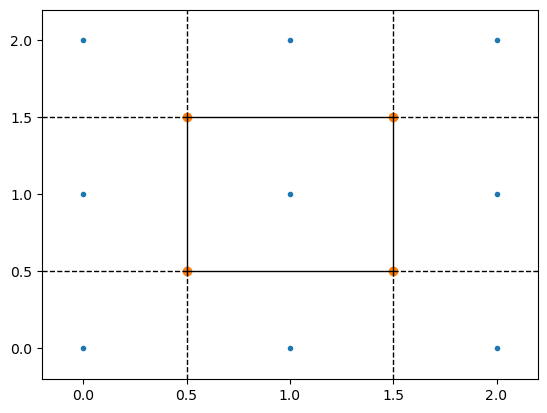

In [23]:
import numpy as np
points = np.array([[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2],
                   [2, 0], [2, 1], [2, 2]])
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(points)
import matplotlib.pyplot as plt
fig = voronoi_plot_2d(vor)
plt.show()

In [29]:
vor.vertices ### Son los vertices

array([[0.5, 0.5],
       [0.5, 1.5],
       [1.5, 0.5],
       [1.5, 1.5]])

In [30]:
vor.ridge_points[:8] ### Si existe una linea entre dos puntos (Por ejemplo entre el 0 y el 3 existe)

array([[0, 3],
       [0, 1],
       [2, 5],
       [2, 1],
       [1, 4],
       [7, 8],
       [7, 6],
       [7, 4]], dtype=int32)

In [31]:
vor.ridge_vertices[:8] ## Si existe una linea entre dos vertices (Por ejemplo entre el 0 [0.5,0.5] y el 1 [0.5,1.5] existe)

[[-1, 0], [-1, 0], [-1, 1], [-1, 1], [0, 1], [-1, 3], [-1, 2], [2, 3]]

In [27]:
vor.regions


[[],
 [-1, 0],
 [-1, 1],
 [1, -1, 0],
 [3, -1, 2],
 [-1, 3],
 [-1, 2],
 [0, 1, 3, 2],
 [2, -1, 0],
 [3, -1, 1]]

In [6]:
vor.points

array([[0., 0.],
       [0., 1.],
       [0., 2.],
       [1., 0.],
       [1., 1.],
       [1., 2.],
       [2., 0.],
       [2., 1.],
       [2., 2.]])

In [7]:
vor.point_region #Index of the Voronoi region for each input poin

array([1, 3, 2, 8, 7, 9, 6, 4, 5], dtype=int64)

In [40]:
for i, r in enumerate(vor.point_region):
    region = vor.regions[r]
    print(region,r,i)

[-1, 0] 1 0
[1, -1, 0] 3 1
[-1, 1] 2 2
[2, -1, 0] 8 3
[0, 1, 3, 2] 7 4
[3, -1, 1] 9 5
[-1, 2] 6 6
[3, -1, 2] 4 7
[-1, 3] 5 8


In [8]:
vor.regions #Indices of the Voronoi vertices forming each Voronoi region. -1 indicates vertex outside the Voronoi diagram.

[[],
 [-1, 0],
 [-1, 1],
 [1, -1, 0],
 [3, -1, 2],
 [-1, 3],
 [-1, 2],
 [0, 1, 3, 2],
 [2, -1, 0],
 [3, -1, 1]]

In [33]:
vor.point_region ### A que region pertece cada punto

array([1, 3, 2, 8, 7, 9, 6, 4, 5])

In [13]:
from collections import defaultdict

from shapely.geometry import Polygon

def voronoi_polygons(voronoi, diameter):
    """Generate shapely.geometry.Polygon objects corresponding to the
    regions of a scipy.spatial.Voronoi object, in the order of the
    input points. The polygons for the infinite regions are large
    enough that all points within a distance 'diameter' of a Voronoi
    vertex are contained in one of the infinite polygons.

    """
    ## Se calcula el centroide (Esto nos servirá luego para determinar la dirección de los bordes infinitos)
    ## De manera general queremos que apunten del centro hacia afuera (y no al revés) para que se expandan hacia los boundaries
    centroid = voronoi.points.mean(axis=0)

    # Mapping from (input point index, Voronoi point index) to list of
    # unit vectors in the directions of the infinite ridges starting
    # at the Voronoi point and neighbouring the input point.

    ridge_direction = defaultdict(list) ## Esto es un diccionario con los puntos y los vectores asociados. Ejem [(0,1):[-1,0],..]
    ## En el caso anterior significaría que la direccion del borde infinito con respecto al punto 0 y el vertice 0 sería [-1,0] (partiendo desde el vertice 0)

    ## Ridge points contiene entre que pares de puntos existe un borde. Ejemplo: [0,3] -> Existe un vertice entre el point 0 y el point 3
    # Ridge vertices contiene entre que pares de vertices existe un borde. Ejemplo: [0,1] -> Existe un vertice entre el vertice 0 y el vertice 1
    # Si pone -1, significa que el vertice es infinito. Eje: [0,-1] -> Hay un borde infinito que parte del vertice 0
    for (p, q), rv in zip(voronoi.ridge_points, voronoi.ridge_vertices):
        u, v = sorted(rv) ## Se ordena por cuestion de comodidad para buscar los bordes infinitos siempre en la primera posicion (u)
        if u == -1:
            ## Se construye el vector que va desde el punto p al punto q
            t = voronoi.points[q] - voronoi.points[p] 

            ## Se extrae el vector normal al pq
            n = np.array([-t[1], t[0]]) / np.linalg.norm(t)

            ## Se calcula el punto medio entre p y q
            midpoint = voronoi.points[[p, q]].mean(axis=0)

            ## Se comprueba si la direccion del vector es la correcta o debe ser la opuesta
            direction = np.sign(np.dot(midpoint - centroid, n)) * n

            ## Se añaden las direccion de los bordes infinitos
            ridge_direction[p, v].append(direction) ### Direccion entre el punto p y el vertice v -> Ejemplo: (0,1):[-1,0] -> Direccion entre el punto 0 y el vertice 1 es [-1,0]
            ridge_direction[q, v].append(direction) ### Direccion entre el punto q y el vertice v
        #print(ridge_direction)
    
    """si el producto escalar es positivo, significa que la dirección debe ser igual a n, y si es negativo, la dirección debe ser igual a -n.
Esto viene de la formula del producto escalar ya que A.B = |A||B|cos(theta). Si el angulo es menor a 90 grados, el coseno es positivo, y si es mayor a 90 grados, el coseno es negativo.
    """

    ## Point region contiene el indice de la region de Voronoi a la que pertenece cada punto
    ## Ejemplo: point_region[0] = 0 -> El punto 0 pertenece a la region 0
    for i, r in enumerate(voronoi.point_region):
        ## Extraemos la region de Voronoi a la que pertenece el punto i
        region = voronoi.regions[r]
        ## En caso de que -1 no esté en la region, significa que es una region finita luego ya habriamos acabado
        if -1 not in region:
            # Finite region.
            yield Polygon(voronoi.vertices[region])
            continue
        # Infinite region.
        inf = region.index(-1)              # Index of vertex at infinity.
        j = region[(inf - 1) % len(region)] # Index of previous vertex.
        k = region[(inf + 1) % len(region)] # Index of next vertex.
        ##La idea de tomar el modulo es porque en caso de que el vertice de Voronoi sea el primero o el ultimo,
        ##el indice anterior es el ultimo del ciclo o el primero del ciclo respectivamente.
        if j == k:
            # Region has one Voronoi vertex with two ridges.
            dir_j, dir_k = ridge_direction[i, j]
        else:
            # Region has two Voronoi vertices, each with one ridge.
            dir_j, = ridge_direction[i, j]
            dir_k, = ridge_direction[i, k]

        # Length of ridges needed for the extra edge to lie at least
        # 'diameter' away from all Voronoi vertices.
        length = 2 * diameter / np.linalg.norm(dir_j + dir_k)

        # Polygon consists of finite part plus an extra edge.
        finite_part = voronoi.vertices[region[inf + 1:] + region[:inf]]
        extra_edge = [voronoi.vertices[j] + dir_j * length,
                      voronoi.vertices[k] + dir_k * length]
        yield Polygon(np.concatenate((finite_part, extra_edge)))

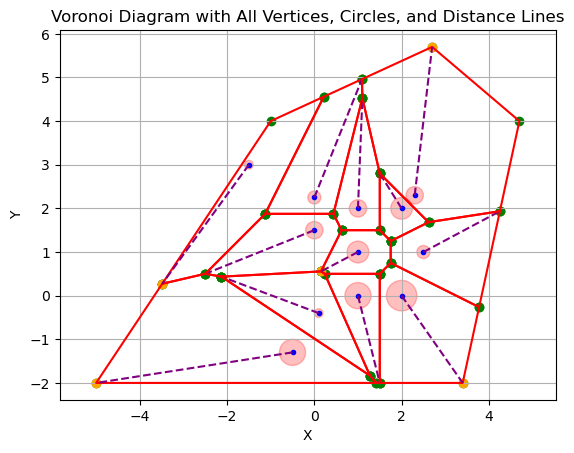

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, Point
from matplotlib.patches import Circle

def find_furthest_vertex(polygon, point):
    distances_to_vertices = [point.distance(Point(x, y)) for x, y in polygon.exterior.coords]
    furthest_vertex_index = distances_to_vertices.index(max(distances_to_vertices))
    return polygon.exterior.coords[furthest_vertex_index]

def plot_voronoi_with_furthest_vertices(vor, boundary, radius_tot):
    x, y = boundary.T
    plt.xlim(round(x.min() - 1), round(x.max() + 1))
    plt.ylim(round(y.min() - 1), round(y.max() + 1))
    plt.plot(*points.T, 'b.')

    diameter = np.linalg.norm(boundary.ptp(axis=0))
    boundary_polygon = Polygon(boundary)

    
    max_distances = []
    for i, p in enumerate(voronoi_polygons(vor, diameter)):
        point_inside = Point(vor.points[i]) 
        polygon = p.intersection(boundary_polygon)

        x, y = zip(*polygon.exterior.coords)
        plt.plot(x, y, 'r-')

        furthest_vertex = find_furthest_vertex(polygon, point_inside)
        plt.scatter(furthest_vertex[0], furthest_vertex[1], color='green', label="Furthest Vertex")

        # Dibuja la línea desde el punto al vértice más lejano
        plt.plot([point_inside.x, furthest_vertex[0]], [point_inside.y, furthest_vertex[1]], linestyle='--', color='purple', label="Distance Line")
        
        # Dibuja un círculo alrededor del punto con el radio correspondiente
        circle_fill = Circle((point_inside.x, point_inside.y), radius_tot[i], color='red', alpha=0.25)
        plt.gca().add_patch(circle_fill)

        # Calcula la máxima distancia
        max_distance = max([point_inside.distance(Point(x, y)) for x, y in polygon.exterior.coords])
        max_distances.append(max_distance)
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Voronoi Diagram with Furthest Vertices, Distance Lines, and Circles')
    plt.grid(True)
    plt.axis('equal')
    plt.show()
    return max_distances


def plot_voronoi_with_all_vertices(vor, boundary, radius_tot):
    x, y = boundary.T
    plt.xlim(round(x.min() - 1), round(x.max() + 1))
    plt.ylim(round(y.min() - 1), round(y.max() + 1))
    plt.plot(*vor.points.T, 'b.')

    diameter = np.linalg.norm(boundary.ptp(axis=0))
    boundary_polygon = Polygon(boundary)

    max_distances = []
    for i, p in enumerate(voronoi_polygons(vor, diameter)):
        point_inside = Point(vor.points[i]) 
        polygon = p.intersection(boundary_polygon)

        x, y = zip(*polygon.exterior.coords)
        plt.plot(x, y, 'r-')

        vertices = np.array(list(polygon.exterior.coords))
        plt.scatter(vertices[:, 0], vertices[:, 1], color='green', label="Vertices")

        furthest_vertex = find_furthest_vertex(polygon, point_inside)
        plt.scatter(furthest_vertex[0], furthest_vertex[1], color='orange', label="Furthest Vertex")

        # Dibuja la línea desde el punto al vértice más lejano
        plt.plot([point_inside.x, furthest_vertex[0]], [point_inside.y, furthest_vertex[1]], linestyle='--', color='purple', label="Distance Line")

        # Dibuja un círculo alrededor del punto con el radio correspondiente
        circle_fill = Circle((point_inside.x, point_inside.y), radius_tot[i], color='red', alpha=0.25)
        plt.gca().add_patch(circle_fill)

        # Calcula la máxima distancia
        max_distance = max([point_inside.distance(Point(x, y)) for x, y in polygon.exterior.coords])
        max_distances.append(max_distance)

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Voronoi Diagram with All Vertices, Circles, and Distance Lines')
    plt.grid(True)
    plt.axis('equal')
    plt.show()
    return max_distances

# Ejemplo de uso
points = np.array([[0.1, -0.4], [0, 1.5], [0, 2.25], [1, 0], [1, 1], [1, 2],
                   [2, 0], [2.5, 1], [2, 2], [2.3, 2.3], [-0.5, -1.3], [-1.5, 3]])
boundary = np.array([[-5, -2], [3.4, -2], [4.7, 4], [2.7, 5.7], [-1, 4]])
radius_tot = np.array([0.1, 0.2, 0.15, 0.3, 0.25, 0.2, 0.35, 0.15, 0.25, 0.2, 0.3, 0.1])
vor = Voronoi(points)
max_distances = plot_voronoi_with_all_vertices(vor, boundary, radius_tot)


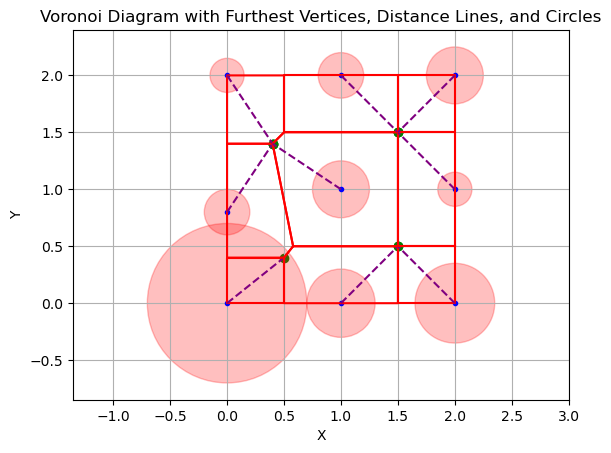

La distancia para el punto 0 es 0.6403124237432849
La distancia para el punto 1 es 0.7211102550927977
La distancia para el punto 2 es 0.7211102550927979
La distancia para el punto 3 es 0.7071067811865476
La distancia para el punto 4 es 0.7211102550927978
La distancia para el punto 5 es 0.7071067811865476
La distancia para el punto 6 es 0.7071067811865476
La distancia para el punto 7 es 0.7071067811865476
La distancia para el punto 8 es 0.7071067811865476


In [67]:
points = np.array([[0, 0], [0, 0.8], [0, 2], [1, 0], [1, 1], [1, 2],
                   [2, 0], [2, 1], [2, 2]])
boundary = np.array([[0.0, 0.0], [0.0, 2.0], [2.0, 2.0], [2.0, 0.0]])
radius_tot = np.array([0.7, 0.2, 0.15, 0.3, 0.25, 0.2, 0.35, 0.15, 0.25, 0.2, 0.3, 0.1])
vor = Voronoi(points)
max_distances = plot_voronoi_with_furthest_vertices(vor, boundary, radius_tot)
for i, d  in enumerate(max_distances):
    print('La distancia para el punto {} es {}'.format(i,d))


In [97]:
def add_new_point_polygon(vor, dists, radius_tot,boundary):
    np.random.seed(seed=0)
    while True:
        # Obtengo aquellas posiciones en las que la distancia es mayor que el radio
        posiciones = [i for i in range(len(dists)) if dists[i] > radius_tot[i]]
        # Si no hay posiciones que cumplan con la condición, retornamos None
        if not posiciones:
            return None
        # Elijo una posición al azar entre las que cumplen con la condición
        posicion = random.choice(posiciones)
        point_inside = Point(vor.points[posicion])
        diameter = np.linalg.norm(boundary.ptp(axis=0))

        ## Cargamos los poligonos que definen cada voronoi set
        polygons_tot = voronoi_polygons(vor, diameter)
        polygons = list(polygons_tot)
        p = polygons[posicion]
        boundary_polygon = Polygon(boundary)
        polygon = p.intersection(boundary_polygon)
        #vertices = np.array(list(polygon.exterior.coords))
        furthest_vertex = find_furthest_vertex(polygon, point_inside)
        new_point = furthest_vertex

        return new_point

Length of the distance line: 1.63


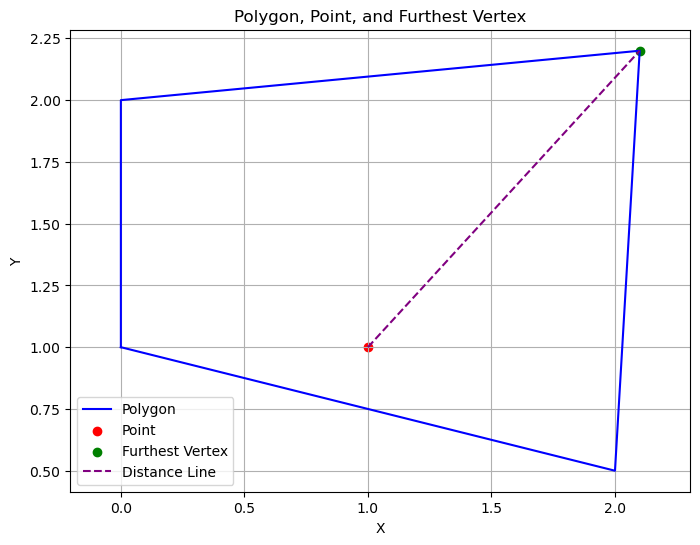

In [49]:
############################################## EJEMPLO DISTANCIA DE UN POLIGONO A UN PUNTO #################################################

def plot_polygon_and_distance(polygon, point_inside):
    # Create a Shapely polygon object
    # Calculate the distance from the point to each vertex of the polygon
    distances_to_vertices = [point_inside.distance(Point(x, y)) for x, y in polygon_vertices]
    # Find the index of the vertex with the maximum distance
    furthest_vertex_index = distances_to_vertices.index(max(distances_to_vertices))
    # Get the coordinates of the furthest vertex
    furthest_vertex = polygon_vertices[furthest_vertex_index]
    # Extract the x and y coordinates of the polygon vertices
    x, y = zip(*polygon.exterior.coords)
    # Plot the polygon
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, label="Polygon", color='blue')
    # Plot the point
    plt.scatter(point_inside.x, point_inside.y, color='red', label="Point")
    # Plot the furthest vertex
    plt.scatter(furthest_vertex[0], furthest_vertex[1], color='green', label="Furthest Vertex")
    # Add labels and legend
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Polygon, Point, and Furthest Vertex')
    # Draw a line from the point to the furthest vertex
    plt.plot([point_inside.x, furthest_vertex[0]], [point_inside.y, furthest_vertex[1]], linestyle='--', color='purple', label="Distance Line")
    # Calculate the length of the distance line
    distance_line_length = point_inside.distance(Point(furthest_vertex))
    print(f"Length of the distance line: {distance_line_length:.2f}")
    # Add legend
    plt.legend()
    # Show the plot
    plt.grid(True)
    plt.axis('equal')
    plt.show()
# Define the coordinates of the polygon's vertices as a list of tuples
polygon_vertices = [(0, 1), (2, 0.5), (2.1, 2.2), (0, 2)]
# Create a Shapely polygon object
polygon = Polygon(polygon_vertices)
# Define the point inside the polygon as a Shapely Point object
point_inside = Point(1, 1)
# Call the function to plot the polygon and distance
plot_polygon_and_distance(polygon, point_inside)

Length of the distance line: 1.63


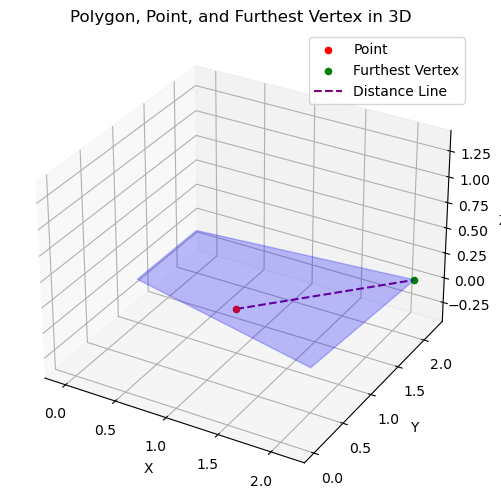

In [66]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from shapely.geometry import Polygon, Point
############################## REPRESENTACION DE DISTANCIA EN 3D #########################################

def plot_polygon_and_distance_3d(polygon, point_inside):
    # Calculate the distance from the point to each vertex of the polygon
    distances_to_vertices = [point_inside.distance(Point(x, y, z)) for x, y, z in polygon_vertices]
    # Find the index of the vertex with the maximum distance
    furthest_vertex_index = distances_to_vertices.index(max(distances_to_vertices))
    # Get the coordinates of the furthest vertex
    furthest_vertex = polygon_vertices[furthest_vertex_index]
    
    # Extract the x, y, and z coordinates of the polygon vertices
    x, y, z = zip(*polygon.exterior.coords)
    
    # Create a 3D plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the polygon
    polygon_3d = [[(xi, yi, zi) for xi, yi, zi in zip(x, y, z)]]
    poly3d = [[polygon_3d[0][furthest_vertex_index]], polygon_3d[0]]
    ax.add_collection3d(Poly3DCollection(poly3d, alpha=0.25, color='blue'))
    
    # Plot the point
    ax.scatter(point_inside.x, point_inside.y, point_inside.z, color='red', label="Point")
    
    # Plot the furthest vertex
    ax.scatter(furthest_vertex[0], furthest_vertex[1], furthest_vertex[2], color='green', label="Furthest Vertex")
    
    # Add labels and legend
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Polygon, Point, and Furthest Vertex in 3D')
    
    # Draw a line from the point to the furthest vertex
    ax.plot([point_inside.x, furthest_vertex[0]], [point_inside.y, furthest_vertex[1]], [point_inside.z, furthest_vertex[2]], linestyle='--', color='purple', label="Distance Line")
    
    # Calculate the length of the distance line
    distance_line_length = point_inside.distance(Point(furthest_vertex))
    print(f"Length of the distance line: {distance_line_length:.2f}")
    
    # Add legend
    ax.legend()
    
    # Show the plot
    plt.grid(True)
    plt.axis('equal')
    plt.show()

# Define the coordinates of the polygon's vertices as a list of tuples in 3D
polygon_vertices = [(0, 1, 0), (2, 0.5, 0), (2.1, 2.2, 0), (0, 2, 0)]

# Create a Shapely polygon object
polygon = Polygon(polygon_vertices)

# Define the point inside the polygon as a Shapely Point object in 3D
point_inside = Point(1, 1, 0)

# Call the function to plot the polygon and distance in 3D
plot_polygon_and_distance_3d(polygon, point_inside)


In [62]:
############################## REPRESENTACION DE DISTANCIA EN 3D #########################################

def distance_to_sphere(point, center, radius):
    # Calcula el vector desde el centro de la esfera hasta el punto
    vector = np.array(point) - np.array(center)
    
    # Calcula la distancia desde el punto exterior al punto más cercano en la superficie de la esfera
    distance = np.linalg.norm(vector) - radius
    
    return distance

def plot_sphere_and_distance_3d_plotly(center, radius, point):
    # Calcula la distancia desde el punto exterior a la esfera
    dist_to_surface = distance_to_sphere(point, center, radius)
    
    # Crea una figura 3D en Plotly
    fig = go.Figure()

    # Dibuja la esfera
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = center[0] + radius * np.outer(np.cos(u), np.sin(v))
    y = center[1] + radius * np.outer(np.sin(u), np.sin(v))
    z = center[2] + radius * np.outer(np.ones(np.size(u)), np.cos(v))
    fig.add_trace(go.Surface(x=x, y=y, z=z, colorscale='Blues', showscale=False))

    # Dibuja el punto exterior a la esfera
    fig.add_trace(go.Scatter3d(x=[point[0]], y=[point[1]], z=[point[2]], mode='markers', marker=dict(size=5, color='red'), name="Point"))

    # Establece el título y las etiquetas de los ejes
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube',
            xaxis_range=[center[0] - radius-1, center[0] + radius+1],  # Ajusta el rango del eje x
            yaxis_range=[center[1] - radius-1, center[1] + radius+1],  # Ajusta el rango del eje y
            zaxis_range=[center[1] - radius-1, center[1] + radius+1],  # Ajusta el rango del eje y
        ),
        title='Sphere, Point, and Distance in 3D (Plotly)',
    )

    # Calcula la distancia a la superficie de la esfera
    print(f"Distance to Sphere Surface: {dist_to_surface:.2f}")

    # Muestra la figura
    fig.show()

# Define el centro y el radio de la esfera
sphere_center = (1, 1, 1)
sphere_radius = 2.0

# Define un punto fuera de la esfera
point_outside = (4, 3, 0)

# Llama a la función para dibujar la esfera y la distancia en 3D con Plotly
plot_sphere_and_distance_3d_plotly(sphere_center, sphere_radius, point_outside)


Distance to Sphere Surface: 1.74


### 2D Voronoi diagram

In [ ]:
### AÑADIENDO UN NUEVO PUNTO AL VORONOI DIAGRAM
np.random.seed(seed=0)

points = np.array([[0, 0.1], [0, 1.5], [0, 2], [1, 0], [1, 1], [1, 2],
                   [2, 0], [2, 1], [2, 2]])
boundary = np.array([[-0.5,-0.5],[2.5,-0.5],[2.5,2.5],[-0.5,2.5]])
vor = Voronoi(points, furthest_site=False,incremental=True)

radius_tot = np.random.uniform(0.1, 0.7,len(vor.points))
dists = plot_voronoi_with_all_vertices(vor, boundary, radius_tot) ## CORREGIR PARA DICCIONARIO



(-0.5, 0.8)


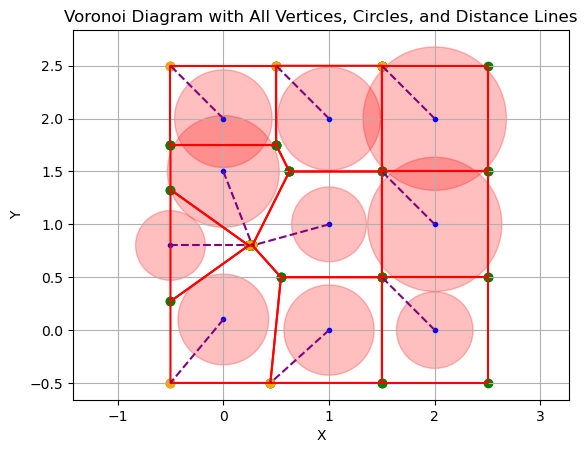

(-0.5, -0.5)


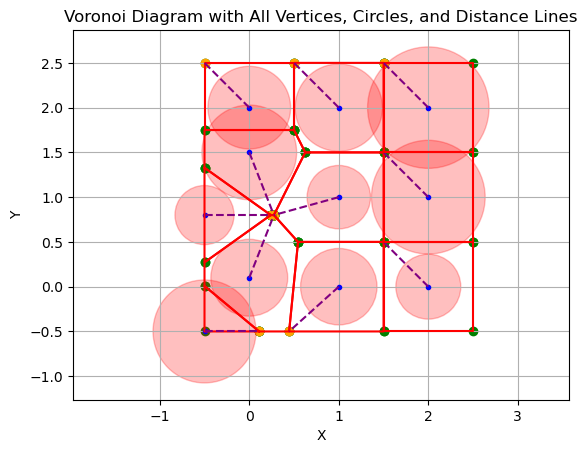

(1.5, 0.5)


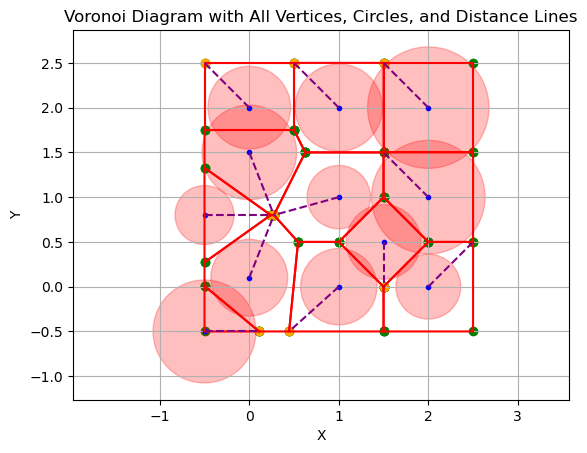

In [107]:
## Añadiendo de forma secuencial nuevos puntos
np.random.seed(seed=0)
boundary = np.array([[-0.5,-0.5],[2.5,-0.5],[2.5,2.5],[-0.5,2.5]])

for i in range(3):
    ### AÑADIENDO UN NUEVO PUNTO AL VORONOI DIAGRAM

    new_point = add_new_point_polygon(vor, dists, radius_tot,boundary)
    print(new_point)
    vor.add_points([new_point])
    radius_tot = np.random.uniform(0.1, 0.7,len(vor.points))
    dists =plot_voronoi_with_all_vertices(vor, boundary, radius_tot)


#### OTRAS PRUEBAS


Distancia al punto más lejano para el punto 0: 1.7128739448247476
Distancia al punto más lejano para el punto 1: 1.4560219778561034
Distancia al punto más lejano para el punto 2: 1.4907119849998598
Distancia al punto más lejano para el punto 3: 1.1236718499972749
Distancia al punto más lejano para el punto 4: 0.7586928205264415
Distancia al punto más lejano para el punto 5: 1.3984723808499044
Distancia al punto más lejano para el punto 6: 1.4927178805757921
Distancia al punto más lejano para el punto 7: 1.4210361134239806
Distancia al punto más lejano para el punto 8: 1.5166123578055608


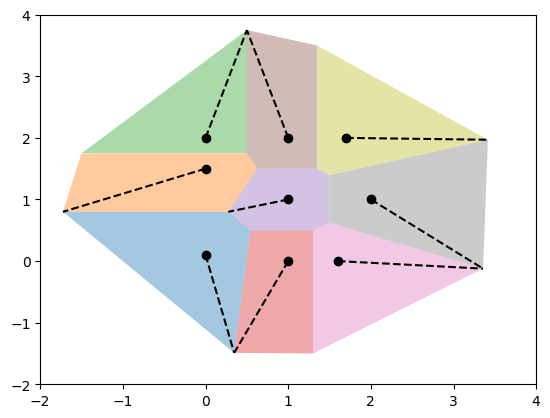

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

### CONSTRUCCIÓN DE LOS VORONOI SETS
points = np.array([[0, 0.1], [0, 1.5], [0, 2], [1, 0], [1, 1], [1, 2],
                   [1.6, 0], [2, 1], [1.7, 2]])

# compute Voronoi tesselation
vor = Voronoi(points)

# plot
regions, vertices = voronoi_finite_polygons_2d(vor)

# Calcular las regiones y vértices finitos del diagrama de Voronoi
regions, vertices = voronoi_finite_polygons_2d(vor)

# Calcular y almacenar las distancias al punto más lejano en cada región

distances_to_farthest_point = []
farthest_points = []  # Almacenar los puntos más lejanos para cada región
for region in regions:
    polygon = vertices[region]
    center = np.mean(polygon, axis=0)
    distances = np.linalg.norm(polygon - center, axis=1)
    farthest_distance = np.max(distances)
    farthest_index = np.argmax(distances)
    distances_to_farthest_point.append(farthest_distance)
    farthest_points.append(polygon[farthest_index])

# Imprimir las distancias para cada punto
for i, distance in enumerate(distances_to_farthest_point):
    print(f"Distancia al punto más lejano para el punto {i}: {distance}")

# colorize
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.4)
# Agregar líneas que conectan cada punto con su punto más lejano
for i, (point, farthest_point) in enumerate(zip(points, farthest_points)):
    plt.plot([point[0], farthest_point[0]], [point[1], farthest_point[1]], 'k--')

plt.plot(points[:,0], points[:,1], 'ko')
plt.xlim(vor.min_bound[0] - 2, vor.max_bound[0] + 2)
plt.ylim(vor.min_bound[1] - 2, vor.max_bound[1] + 2)

plt.show()

Punto [0.  0.1] distancia máxima: 0.7520804478245663
Punto [0.  1.5] distancia máxima: 0.7520804478245662
Punto [0. 2.] distancia máxima: 0.5590169943749475
Punto [1. 0.] distancia máxima: 0.6760362416320593
Punto [1. 1.] distancia máxima: 0.7520804478245661
Punto [1. 2.] distancia máxima: 0.625
Punto [1.6 0. ] distancia máxima: 0.6280127387243033
Punto [2. 1.] distancia máxima: 0.6372009102316161
Punto [1.7 2. ] distancia máxima: 0.6372009102316161


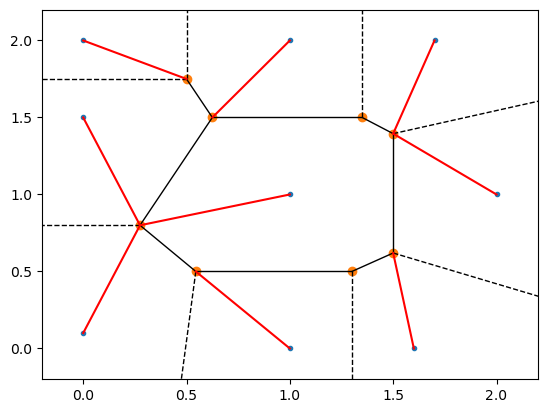

In [38]:
### CONSTRUCCIÓN DE LOS VORONOI SETS
points = np.array([[0, 0.1], [0, 1.5], [0, 2], [1, 0], [1, 1], [1, 2],
                   [1.6, 0], [2, 1], [1.7, 2]])

vor = Voronoi(points, furthest_site=False)

fig = voronoi_plot_2d(vor)
dists = []

for i, point in enumerate(points):

    # get nearby vertices
    ridges = np.where(vor.ridge_points == i)[0]
    vertex_set = set(np.array(vor.ridge_vertices)[ridges, :].ravel())
    region = [x for x in vor.regions if set(x) == vertex_set][0]
    region = [x for x in region if x != -1]  # remove outliers
    polygon = vor.vertices[region]
    if len(polygon) < 1:
        continue

    # calc distance of every vertex to the initial point
    distances = cdist([point], polygon).T
    max_dist_idx = np.argmax(distances)
    max_dist = distances[max_dist_idx][0]  # Extract the scalar value
    dists.append(max_dist)

    # just for visuals
    xvals = [point[0], polygon[max_dist_idx][0]]
    yvals = [point[1], polygon[max_dist_idx][1]]
    plt.plot(xvals, yvals, 'r-')


    # Print distance information
    print(f'Punto {point} distancia máxima: {max_dist}')

plt.show()

In [40]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.morphology import binary_erosion
from scipy.spatial import Voronoi
from shapely.geometry import Point, Polygon
from skimage import draw
from sklearn.neighbors import KDTree

def get_circular_se(radius=2):

    N = (radius * 2) + 1
    se = np.zeros(shape=[N,N])
    for i in range(N):
        for j in range(N):
                se[i,j] = (i - N / 2)**2 + (j - N / 2)**2 <= radius**2
    se = np.array(se, dtype="uint8")
    return se

def polygonize_by_nearest_neighbor(pp):
    """Takes a set of xy coordinates pp Numpy array(n,2) and reorders the array to make
    a polygon using a nearest neighbor approach.

    """

    # start with first index
    pp_new = np.zeros_like(pp)
    pp_new[0] = pp[0]
    p_current_idx = 0

    tree = KDTree(pp)

    for i in range(len(pp) - 1):

        nearest_dist, nearest_idx = tree.query([pp[p_current_idx]], k=4)  # k1 = identity
        nearest_idx = nearest_idx[0]

        # finds next nearest point along the contour and adds it
        for min_idx in nearest_idx[1:]:  # skip the first point (will be zero for same pixel)
            if not pp[min_idx].tolist() in pp_new.tolist():  # make sure it's not already in the list
                pp_new[i + 1] = pp[min_idx]
                p_current_idx = min_idx
                break

    pp_new[-1] = pp[0]
    return pp_new


#generates a circular mask
side_len = 512
rad = 100
mask = np.zeros(shape=(side_len, side_len))
rr, cc = draw.circle(side_len/2, side_len/2, radius=rad, shape=mask.shape)
mask[rr, cc] = 1

#makes a polygon from the mask perimeter
se = get_circular_se(radius=1)
contour = mask - binary_erosion(mask, structure=se)
pixels_mask = np.array(np.where(contour==1)[::-1]).T
polygon = polygonize_by_nearest_neighbor(pixels_mask)
polygon = Polygon(polygon)

#generates random seeds
points_x = np.random.random_integers(0,side_len,250)
points_y = np.random.random_integers(0,side_len,250)
points = (np.vstack((points_x,points_y))).T

# returns a list of the centroids that are contained within the polygon
new_points = []
for point in points:
    if polygon.contains(Point(point)):
        new_points.append(point)

#performs voronoi tesselation
if len(points) > 3: #otherwise the tesselation won't work
    vor = Voronoi(new_points)
    regions, vertices = voronoi_finite_polygons_2d(vor)

    #clips tesselation to the mask
    new_vertices = []
    for region in regions:
        poly_reg = vertices[region]
        shape = list(poly_reg.shape)
        shape[0] += 1
        p = Polygon(np.append(poly_reg, poly_reg[0]).reshape(*shape)).intersection(polygon)
        poly = (np.array(p.exterior.coords)).tolist()
        new_vertices.append(poly)

    #plots the results
    fig, ax = plt.subplots()
    ax.imshow(mask,cmap='Greys_r')
    for poly in new_vertices:
        ax.fill(*zip(*poly), alpha=0.7)
    ax.plot(points[:,0],points[:,1],'ro',ms=2)
    plt.show()

C:\Users\apolo\AppData\Local\Temp\ipykernel_51408\536964115.py:3: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_erosion


AttributeError: No skimage.draw attribute circle

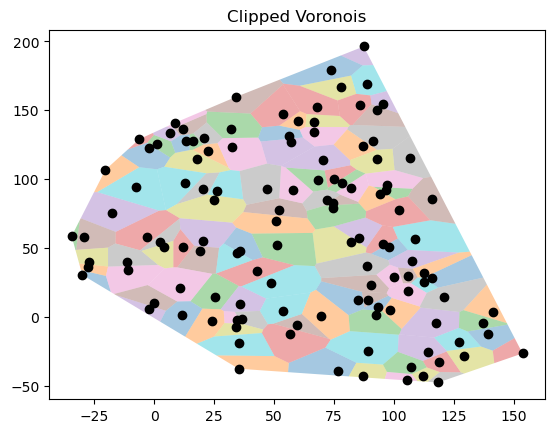

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import MultiPoint, Point, Polygon
from scipy.spatial import Voronoi

points = [[-30.0, 30.370371], [-27.777777, 35.925926], [-34.444443, 58.51852], [-2.9629631, 57.777779], [-17.777779, 75.185181], [-29.25926, 58.148151], [-11.111112, 33.703705], [-11.481482, 40.0], [-27.037037, 40.0], [-7.7777777, 94.444443], [-2.2222223, 122.22222], [-20.370371, 106.66667], [1.1111112, 125.18518], [-6.2962961, 128.88889], [6.666667, 133.7037], [11.851852, 136.2963], [8.5185184, 140.74074], [20.370371, 92.962959], [17.777779, 114.81482], [12.962962, 97.037041], [13.333334, 127.77778], [22.592592, 120.37037], [16.296295, 127.77778], [11.851852, 50.740742], [20.370371, 54.814816], [19.25926, 47.40741], [32.59259, 122.96296], [20.74074, 130.0], [24.814816, 84.814819], [26.296295, 91.111107], [56.296295, 131.48149], [60.0, 141.85185], [32.222221, 136.66667], [53.703705, 147.03703], [87.40741, 196.2963], [34.074074, 159.62964], [34.444443, -2.5925925], [36.666668, -1.8518518], [34.074074, -7.4074073], [35.555557, -18.888889], [76.666664, -39.629627], [35.185184, -37.777779], [25.185184, 14.074074], [42.962959, 32.962963], [35.925926, 9.2592592], [52.222221, 77.777779], [57.777779, 92.222221], [47.037041, 92.59259], [82.222221, 54.074074], [48.888889, 24.444445], [35.925926, 47.777779], [50.740742, 69.259254], [51.111111, 51.851849], [56.666664, -12.222222], [117.40741, -4.4444447], [59.629631, -5.9259262], [66.666664, 134.07408], [91.481483, 127.40741], [66.666664, 141.48149], [53.703705, 4.0740738], [85.185181, 11.851852], [69.629631, 0.37037039], [68.518517, 99.259262], [75.185181, 100.0], [70.370369, 113.7037], [74.444443, 82.59259], [82.222221, 93.703697], [72.222221, 84.444443], [77.777779, 167.03703], [88.888893, 168.88889], [73.703705, 178.88889], [87.037041, 123.7037], [78.518517, 97.037041], [95.555557, 52.962959], [85.555557, 57.037041], [90.370369, 23.333332], [100.0, 28.51852], [88.888893, 37.037037], [87.037041, -42.962959], [89.259262, -24.814816], [93.333328, 7.4074073], [98.518517, 5.185185], [92.59259, 1.4814816], [85.925919, 153.7037], [95.555557, 154.44444], [92.962959, 150.0], [97.037041, 95.925919], [106.66667, 115.55556], [92.962959, 114.81482], [108.88889, 56.296295], [97.777779, 50.740742], [94.074081, 89.259262], [96.666672, 91.851852], [102.22222, 77.777779], [107.40741, 40.370369], [105.92592, 29.629629], [105.55556, -46.296295], [118.51852, -47.777779], [112.22222, -43.333336], [112.59259, 25.185184], [115.92592, 27.777777], [112.59259, 31.851852], [107.03704, -36.666668], [118.88889, -32.59259], [114.07408, -25.555555], [115.92592, 85.185181], [105.92592, 18.888889], [121.11111, 14.444445], [129.25926, -28.51852], [127.03704, -18.518518], [139.25926, -12.222222], [141.48149, 3.7037036], [137.03703, -4.814815], [153.7037, -26.666668], [-2.2222223, 5.5555558], [0.0, 9.6296301], [10.74074, 20.74074], [2.2222223, 54.074074], [4.0740738, 50.740742], [34.444443, 46.296295], [11.481482, 1.4814816], [24.074076, -2.9629631], [74.814819, 79.259254], [67.777779, 152.22223], [57.037041, 127.03704], [89.259262, 12.222222]]

points = np.array(points)

vor = Voronoi(points)

regions, vertices = voronoi_finite_polygons_2d(vor)

pts = MultiPoint([Point(i) for i in points])
mask = pts.convex_hull
new_vertices = []
for region in regions:
    polygon = vertices[region]
    shape = list(polygon.shape)
    shape[0] += 1
    p = Polygon(np.append(polygon, polygon[0]).reshape(*shape)).intersection(mask)
    poly = np.array(list(zip(p.boundary.coords.xy[0][:-1], p.boundary.coords.xy[1][:-1])))
    new_vertices.append(poly)
    plt.fill(*zip(*poly), alpha=0.4)
plt.plot(points[:,0], points[:,1], 'ko')
plt.title("Clipped Voronois")
plt.show()

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.ops import polygonize,unary_union
from shapely.geometry import LineString, MultiPolygon, MultiPoint, Point
from scipy.spatial import Voronoi
points = [[-30.0, 30.370371], [-27.777777, 35.925926], [-34.444443, 58.51852], [-2.9629631, 57.777779], [-17.777779, 75.185181], [-29.25926, 58.148151], [-11.111112, 33.703705], [-11.481482, 40.0], [-27.037037, 40.0], [-7.7777777, 94.444443], [-2.2222223, 122.22222], [-20.370371, 106.66667], [1.1111112, 125.18518], [-6.2962961, 128.88889], [6.666667, 133.7037], [11.851852, 136.2963], [8.5185184, 140.74074], [20.370371, 92.962959], [17.777779, 114.81482], [12.962962, 97.037041], [13.333334, 127.77778], [22.592592, 120.37037], [16.296295, 127.77778], [11.851852, 50.740742], [20.370371, 54.814816], [19.25926, 47.40741], [32.59259, 122.96296], [20.74074, 130.0], [24.814816, 84.814819], [26.296295, 91.111107], [56.296295, 131.48149], [60.0, 141.85185], [32.222221, 136.66667], [53.703705, 147.03703], [87.40741, 196.2963], [34.074074, 159.62964], [34.444443, -2.5925925], [36.666668, -1.8518518], [34.074074, -7.4074073], [35.555557, -18.888889], [76.666664, -39.629627], [35.185184, -37.777779], [25.185184, 14.074074], [42.962959, 32.962963], [35.925926, 9.2592592], [52.222221, 77.777779], [57.777779, 92.222221], [47.037041, 92.59259], [82.222221, 54.074074], [48.888889, 24.444445], [35.925926, 47.777779], [50.740742, 69.259254], [51.111111, 51.851849], [56.666664, -12.222222], [117.40741, -4.4444447], [59.629631, -5.9259262], [66.666664, 134.07408], [91.481483, 127.40741], [66.666664, 141.48149], [53.703705, 4.0740738], [85.185181, 11.851852], [69.629631, 0.37037039], [68.518517, 99.259262], [75.185181, 100.0], [70.370369, 113.7037], [74.444443, 82.59259], [82.222221, 93.703697], [72.222221, 84.444443], [77.777779, 167.03703], [88.888893, 168.88889], [73.703705, 178.88889], [87.037041, 123.7037], [78.518517, 97.037041], [95.555557, 52.962959], [85.555557, 57.037041], [90.370369, 23.333332], [100.0, 28.51852], [88.888893, 37.037037], [87.037041, -42.962959], [89.259262, -24.814816], [93.333328, 7.4074073], [98.518517, 5.185185], [92.59259, 1.4814816], [85.925919, 153.7037], [95.555557, 154.44444], [92.962959, 150.0], [97.037041, 95.925919], [106.66667, 115.55556], [92.962959, 114.81482], [108.88889, 56.296295], [97.777779, 50.740742], [94.074081, 89.259262], [96.666672, 91.851852], [102.22222, 77.777779], [107.40741, 40.370369], [105.92592, 29.629629], [105.55556, -46.296295], [118.51852, -47.777779], [112.22222, -43.333336], [112.59259, 25.185184], [115.92592, 27.777777], [112.59259, 31.851852], [107.03704, -36.666668], [118.88889, -32.59259], [114.07408, -25.555555], [115.92592, 85.185181], [105.92592, 18.888889], [121.11111, 14.444445], [129.25926, -28.51852], [127.03704, -18.518518], [139.25926, -12.222222], [141.48149, 3.7037036], [137.03703, -4.814815], [153.7037, -26.666668], [-2.2222223, 5.5555558], [0.0, 9.6296301], [10.74074, 20.74074], [2.2222223, 54.074074], [4.0740738, 50.740742], [34.444443, 46.296295], [11.481482, 1.4814816], [24.074076, -2.9629631], [74.814819, 79.259254], [67.777779, 152.22223], [57.037041, 127.03704], [89.259262, 12.222222]]
points = np.array(points)
vor = Voronoi(points)
lines = [
    LineString(vor.vertices[line])
    for line in vor.ridge_vertices if -1 not in line
]

convex_hull = MultiPoint([Point(i) for i in points]).convex_hull.buffer(2)
result = MultiPolygon(
    [poly.intersection(convex_hull) for poly in polygonize(lines)])
result = MultiPolygon(
    [p for p in result]
    + [p for p in convex_hull.difference(unary_union(result))])

plt.plot(points[:,0], points[:,1], 'ko')
for r in result:
    plt.fill(*zip(*np.array(list(
        zip(r.boundary.coords.xy[0][:-1], r.boundary.coords.xy[1][:-1])))),
        alpha=0.4)
plt.show()

TypeError: 'MultiPolygon' object is not iterable

Punto [0.  0.1] distancia máxima: 0.7520804478245663
Punto [0.  1.5] distancia máxima: 0.7520804478245662
Punto [0. 2.] distancia máxima: 0.5590169943749475
Punto [1. 0.] distancia máxima: 0.6760362416320593
Punto [1. 1.] distancia máxima: 0.7520804478245661
Punto [1. 2.] distancia máxima: 0.625
Punto [1.6 0. ] distancia máxima: 0.6280127387243033
Punto [2. 1.] distancia máxima: 0.6372009102316161
Punto [1.7 2. ] distancia máxima: 0.6372009102316161


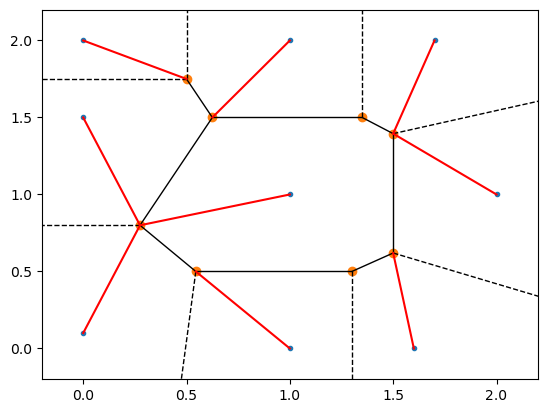

In [6]:
### CONSTRUCCIÓN DE LOS VORONOI SETS
points = np.array([[0, 0.1], [0, 1.5], [0, 2], [1, 0], [1, 1], [1, 2],
                   [1.6, 0], [2, 1], [1.7, 2]])

vor = Voronoi(points, furthest_site=False)

fig = voronoi_plot_2d(vor)
dists = []

for i, point in enumerate(points):

    # get nearby vertices
    ridges = np.where(vor.ridge_points == i)[0]
    vertex_set = set(np.array(vor.ridge_vertices)[ridges, :].ravel())
    region = [x for x in vor.regions if set(x) == vertex_set][0]
    region = [x for x in region if x != -1]  # remove outliers
    polygon = vor.vertices[region]
    if len(polygon) < 1:
        continue

    # calc distance of every vertex to the initial point
    distances = cdist([point], polygon).T
    max_dist_idx = np.argmax(distances)
    max_dist = distances[max_dist_idx][0]  # Extract the scalar value
    dists.append(max_dist)

    # just for visuals
    xvals = [point[0], polygon[max_dist_idx][0]]
    yvals = [point[1], polygon[max_dist_idx][1]]
    plt.plot(xvals, yvals, 'r-')


    # Print distance information
    print(f'Punto {point} distancia máxima: {max_dist}')

plt.show()


In [8]:
points = np.array([[0, 0.1], [0, 1.5], [0, 2], [1, 0], [1, 1], [1, 2],
                   [1.6, 0], [2, 1], [1.7, 2]])

vor = Voronoi(points, furthest_site=False)
vor

In [10]:
vor.vertices

array([[1.5  , 1.395],
       [1.5  , 0.62 ],
       [0.275, 0.8  ],
       [1.35 , 1.5  ],
       [0.5  , 1.75 ],
       [0.625, 1.5  ],
       [0.545, 0.5  ],
       [1.3  , 0.5  ]])

Punto [0.  0.1] distancia máxima: 0.7520804478245663, radio: 0.5220734627339192
Punto [0.  1.5] distancia máxima: 0.7520804478245662, radio: 0.6269534585783032
Punto [0. 2.] distancia máxima: 0.5590169943749475, radio: 0.3666330525677169
Punto [1. 0.] distancia máxima: 0.7071067811865476, radio: 0.8663253361627032
Punto [1. 1.] distancia máxima: 0.7520804478245661, radio: 0.6476570026455757
Punto [1. 2.] distancia máxima: 0.7071067811865476, radio: 0.9853626697967213
Punto [2. 0.] distancia máxima: 0.7071067811865476, radio: 0.7801182152261334
Punto [2. 1.] distancia máxima: 0.7071067811865476, radio: 0.7623083972687257
Punto [2. 2.] distancia máxima: 0.7071067811865476, radio: 0.5882359830443766
El espacio no está relleno.


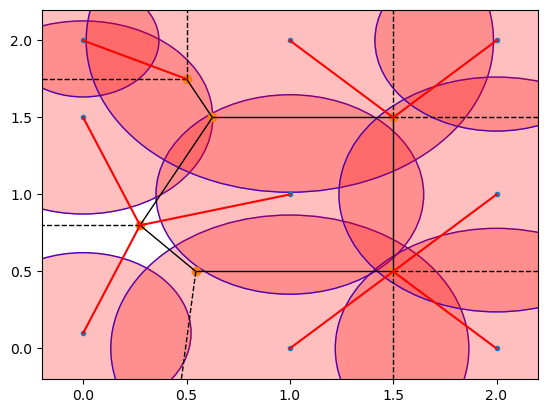

In [2]:
points = np.array([[0, 0.1], [0, 1.5], [0, 2], [1, 0], [1, 1], [1, 2],
                   [2, 0], [2, 1], [2, 2]])

vor = Voronoi(points, furthest_site=False)

fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax)
dists = []

max_distances = []  # To track the maximum distance for each point
radius_tot = []
for i, point in enumerate(points):

    # Generate a random radius between 0 and 0.5
    radius = np.random.uniform(0.2, 1)
    radius_tot.append(radius)

    # Update the maximum distance
    distances = cdist([point], vor.vertices).T
    max_dist = np.max(distances)
    max_distances.append(max_dist)

    # Plot a circle around the point with the chosen radius
    circle = Circle((point[0], point[1]), radius, color='blue', fill=False)
    ax.add_patch(circle)

    # Fill the interior of the circle in red with alpha 0.25
    circle_fill = Circle((point[0], point[1]), radius, color='red', alpha=0.25)
    ax.add_patch(circle_fill)

    # get nearby vertices
    ridges = np.where(vor.ridge_points == i)[0]
    vertex_set = set(np.array(vor.ridge_vertices)[ridges, :].ravel())
    region = [x for x in vor.regions if set(x) == vertex_set][0]
    region = [x for x in region if x != -1]  # remove outliers
    polygon = vor.vertices[region]
    if len(polygon) < 1:
        continue

    # calc distance of every vertex to the initial point
    distances = cdist([point], polygon).T
    max_dist_idx = np.argmax(distances)
    max_dist = distances[max_dist_idx][0]  # Extract the scalar value
    dists.append(max_dist)

    # just for visuals
    xvals = [point[0], polygon[max_dist_idx][0]]
    yvals = [point[1], polygon[max_dist_idx][1]]
    plt.plot(xvals, yvals, 'r-')

    # Print distance and radius information
    print(f'Punto {point} distancia máxima: {max_dist}, radio: {radius}')

# Check if all radii are greater than their respective distances
if all(radius > dist for radius, dist in zip(radius_tot, dists)):
    print("El espacio está relleno.")
else:
    print("El espacio no está relleno.")

plt.show()

## 3D VORONOI DIAGRAM

In [ ]:
import numpy as np
import pyvoro
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# initialize random number generator
rng = np.random.default_rng(11)
# create a set of points in 3D
#points = rng.uniform(size=(15,3))

# use pyvoro to compute the Voronoi tessellation
# the second argument gives the the axis limits in x,y and z direction
# in this case all between 0 and 1.
# the third argument gives "dispersion = max distance between two points
# that might be adjacent" (not sure how exactly this works)
voronoi = pyvoro.compute_voronoi(points,[[0,1],[0,1],[0,1]],1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# for each Voronoi cell, plot all the faces of the corresponding polygon
for vnoicell in voronoi:
    faces = []
    # the vertices are the corner points of the Voronoi cell
    vertices = np.array(vnoicell['vertices'])
    # cycle through all faces of the polygon
    for face in vnoicell['faces']:
        faces.append(vertices[np.array(face['vertices'])])
        
    # join the faces into a 3D polygon
    polygon = Poly3DCollection(faces, alpha=0.5, 
                               facecolors=rng.uniform(0,1,3),
                               linewidths=0.5,edgecolors='black')
    ax.add_collection3d(polygon)

In [62]:
import numpy as np
import pyvoro
import plotly.graph_objects as go

# Initialize random number generator
rng = np.random.default_rng(11)

# Create a set of points in 3D
#points = rng.uniform(size=(15, 3))

# Use pyvoro to compute the Voronoi tessellation
# The second argument gives the axis limits in x, y, and z direction
# In this case, all between 0 and 1.
# The third argument gives "dispersion = max distance between two points
# that might be adjacent" (not sure how exactly this works)
voronoi = pyvoro.compute_voronoi(points, [[0, 1], [0, 1], [0, 1]], 1)

# Create a list to hold the Voronoi polygons
polygons = []

# For each Voronoi cell, create a Polygon3D object
for vnoicell in voronoi:
    faces = []
    vertices = np.array(vnoicell['vertices'])
    for face in vnoicell['faces']:
        faces.append(vertices[np.array(face['vertices'])])
    polygons.append(go.Mesh3d(x=vertices[:, 0], y=vertices[:, 1], z=vertices[:, 2], opacity=0.5, alphahull=0, colorscale='Viridis'))

# Create a 3D scatter plot for the input points
scatter = go.Scatter3d(x=points[:, 0], y=points[:, 1], z=points[:, 2], mode='markers', marker=dict(size=5))

# Create the 3D figure
fig = go.Figure(data=[scatter] + polygons)

# Set layout options
fig.update_layout(scene=dict(aspectmode="cube"))

# Show the plot
fig.show()


In [11]:
import numpy as np
from scipy.spatial import Voronoi
import plotly.graph_objects as go

# Inicializa el generador de números aleatorios
rng = np.random.default_rng(11)

# Crea un conjunto de puntos en 3D

# Calcula la tessellación de Voronoi
vor = Voronoi(points)

# Crea una lista para almacenar los polígonos de Voronoi
polygons = []

# Para cada celda de Voronoi, crea un objeto Polygon3D
for region in vor.regions:
    if not -1 in region and len(region) > 0:
        vertices = [vor.vertices[i] for i in region]
        polygons.append(go.Mesh3d(x=[v[0] for v in vertices],
                                  y=[v[1] for v in vertices],
                                  z=[v[2] for v in vertices],
                                  opacity=0.5, alphahull=0, colorscale='Viridis'))

# Crea una gráfica 3D de dispersión para los puntos de entrada
scatter = go.Scatter3d(x=points[:, 0], y=points[:, 1], z=points[:, 2], mode='markers', marker=dict(size=5))

# Crea la figura 3D
fig = go.Figure(data=[scatter] + polygons)

# Configura las opciones de diseño
fig.update_layout(scene=dict(aspectmode="cube"))

# Muestra la gráfica
fig.show()


#### UNDERSTADING VORONOI 

In [42]:
import numpy as np
import plotly.graph_objs as go
from scipy.spatial import Voronoi

# Número de divisiones en cada lado del cubo de Rubik (3x3x3)
n = 3

# Inicializar un array vacío para almacenar los puntos
points = []

# Calcular el paso entre los puntos en cada dimensión
step = 1.0 / n

# Generar los puntos en el centro de cada subcubo
for i in range(n):
    for j in range(n):
        for k in range(n):
            x = (i + 0.5) * step
            y = (j + 0.5) * step
            z = (k + 0.5) * step
            points.append([x, y, z])

# Convertir la lista de puntos en un array NumPy
points = np.array(points)

# Calcular el diagrama de Voronoi
vor = Voronoi(points)

# Crear una figura 3D de Plotly
fig = go.Figure()

# Agregar los puntos originales en color azul junto con su índice
for idx, point in enumerate(points):
    fig.add_trace(go.Scatter3d(
        x=[point[0]],
        y=[point[1]],
        z=[point[2]],
        mode='markers+text',  # Agregar texto a los puntos
        text=[str(idx)],  # Usar el índice como texto
        textposition='top center',  # Posición del texto
        marker=dict(
            size=5,
            color='blue',  # Color de los puntos originales
            opacity=0.8
        ),
        name=f'Punto {idx}'  # Etiqueta del punto
    ))

# Agregar los vértices del diagrama de Voronoi en color rojo
fig.add_trace(go.Scatter3d(
    x=vor.vertices[:, 0],
    y=vor.vertices[:, 1],
    z=vor.vertices[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color='red',  # Color de los vértices
        opacity=0.8
    ),
    name='Vértices de Voronoi'
))

# Configurar el diseño de la escena 3D
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z'
    )
)

# Mostrar la figura
fig.show()


In [34]:
vor.points[[21,22]]

array([[0.83333333, 0.5       , 0.16666667],
       [0.83333333, 0.5       , 0.5       ]])

In [31]:
## Generamos el diagrama de Voronoi para los puntos
vor = Voronoi(points)

In [32]:
vor.ridge_points[:3]

array([[22, 21],
       [22, 19],
       [22, 25]], dtype=int32)

In [24]:
vor.vertices[vor.regions[2]]

array([[0.33333333, 0.33333333, 0.66666667],
       [0.66666667, 0.66666667, 0.33333333],
       [0.66666667, 0.33333333, 0.33333333]])

array([[0.83333333, 0.5       , 0.16666667],
       [0.83333333, 0.5       , 0.5       ]])

In [17]:
vor.regions[:5]

[[], [-1, 0, 1, 2, 3], [-1, 2, 3], [-1, 2, 4], [-1, 0, 2]]

In [14]:
vor.vertices

array([[0.66666667, 0.66666667, 0.66666667],
       [0.66666667, 0.33333333, 0.66666667],
       [0.66666667, 0.66666667, 0.33333333],
       [0.66666667, 0.33333333, 0.33333333],
       [0.33333333, 0.66666667, 0.33333333],
       [0.33333333, 0.66666667, 0.66666667],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.66666667]])

In [10]:
vor.vertices

array([[0.66666667, 0.66666667, 0.66666667],
       [0.66666667, 0.33333333, 0.66666667],
       [0.66666667, 0.66666667, 0.33333333],
       [0.66666667, 0.33333333, 0.33333333],
       [0.33333333, 0.66666667, 0.33333333],
       [0.33333333, 0.66666667, 0.66666667],
       [0.33333333, 0.33333333, 0.33333333],
       [0.33333333, 0.33333333, 0.66666667]])

## EXTRA

Punto más alejado en el Voronoi set [0.56737818 0.36482236]: [0.58698743 0.02550413], Distancia: 0.33988436920875037
Punto más alejado en el Voronoi set [0.80002201 0.57281244]: [0.6696015  0.21018611], Distancia: 0.38536652511794955
Punto más alejado en el Voronoi set [0.27179518 1.41664977]: [-0.11590991  3.29510251], Distancia: 1.9180458677808778
Punto más alejado en el Voronoi set [0.59547541 0.73110681]: [0.43756855 0.76843988], Distancia: 0.1622600870206307
Punto más alejado en el Voronoi set [0.32879018 0.58550166]: [0.34822683 0.30284865], Distancia: 0.28332050402226644


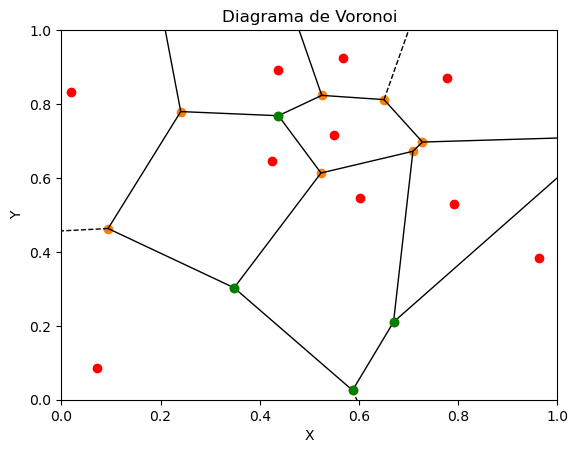

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial.distance import euclidean

# Generar puntos aleatorios en 2D
np.random.seed(0)
num_points = 10
points = np.random.rand(num_points, 2)

# Calcular el diagrama de Voronoi
vor = Voronoi(points)

# Graficar los voronoi sets
voronoi_plot_2d(vor)
plt.plot(points[:, 0], points[:, 1], 'ro')  # Pintar los puntos originales
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Diagrama de Voronoi')
plt.xlabel('X')
plt.ylabel('Y')

# Encontrar y mostrar el punto más alejado en cada Voronoi set
for region in vor.regions:
    if not -1 in region and len(region) > 0:
        vertices = vor.vertices[region]
        center = np.mean(vertices, axis=0)
        max_distance = max([euclidean(center, v) for v in vertices])
        max_distance_point = vertices[np.argmax([euclidean(center, v) for v in vertices])]
        plt.plot(max_distance_point[0], max_distance_point[1], 'go')  # Pintar el punto más alejado
        print(f'Punto más alejado en el Voronoi set {center}: {max_distance_point}, Distancia: {max_distance}')

plt.show()


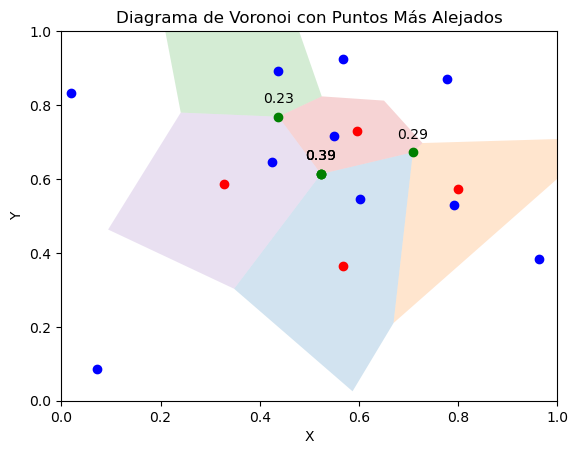

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from scipy.spatial.distance import euclidean

# Generar puntos aleatorios en 2D
np.random.seed(0)
num_points = 10
points = np.random.rand(num_points, 2)

# Calcular el diagrama de Voronoi
vor = Voronoi(points)

# Calcular el punto más alejado dentro del Voronoi set considerando los límites del cuadrado
def get_max_distance_within_boundary(vertices, boundary):
    max_distance = 0
    max_distance_point = None

    for v in vertices:
        distance_to_boundary = min(
            v[0], boundary[1] - v[0], v[1], boundary[3] - v[1]
        )
        if distance_to_boundary > max_distance:
            max_distance = distance_to_boundary
            max_distance_point = v

    return max_distance, max_distance_point

# Graficar los Voronoi sets y los puntos más alejados
for region in vor.regions:
    if not -1 in region and len(region) > 0:
        vertices = vor.vertices[region]
        center = np.mean(vertices, axis=0)
        max_distance, max_distance_point = get_max_distance_within_boundary(vertices, [0, 1, 0, 1])
        
        plt.fill(*zip(*vertices), alpha=0.2)  # Rellenar el Voronoi set
        plt.plot(center[0], center[1], 'ro')  # Pintar el centro del Voronoi set
        plt.plot(max_distance_point[0], max_distance_point[1], 'go')  # Pintar el punto más alejado

        plt.annotate(
            f'{max_distance:.2f}',  # Etiqueta de distancia
            max_distance_point,
            textcoords="offset points",
            xytext=(0,10),
            ha='center'
        )

# Pintar los puntos originales
plt.plot(points[:, 0], points[:, 1], 'bo')

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.title('Diagrama de Voronoi con Puntos Más Alejados')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


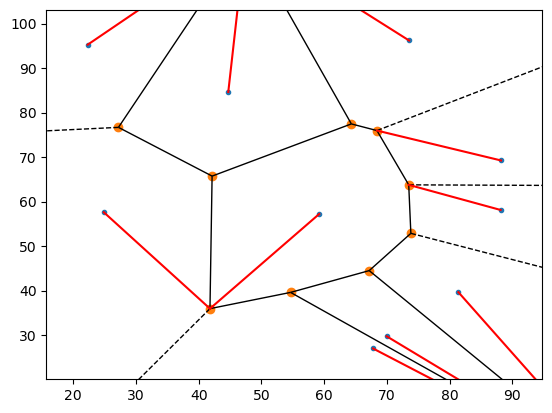

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d, distance


points = np.random.uniform(0, 100, size=(10, 2))
vor = Voronoi(points)
voronoi_plot_2d(vor)

dists = []

for i,point in enumerate(points):

    # get nearby vertices
    ridges = np.where(vor.ridge_points == i)[0]
    vertex_set = set(np.array(vor.ridge_vertices)[ridges, :].ravel())
    region = [x for x in vor.regions if set(x) == vertex_set][0]
    region = [x for x in region if x != -1] # remove outliers
    polygon = vor.vertices[region]
    if len(polygon) < 1:
        continue

    # calc distance of every vertex to the initial point
    distances = distance.cdist([point], polygon).T
    max_dist_idx = np.argmax(distances)
    max_dist = distances[max_dist_idx]
    dists.append(max_dist)

    # just for visuals
    xvals = [point[0], polygon[max_dist_idx][0]]
    yvals = [point[1], polygon[max_dist_idx][1]]
    plt.plot(xvals,yvals,'r-')
    # do stuff with that info

plt.show()

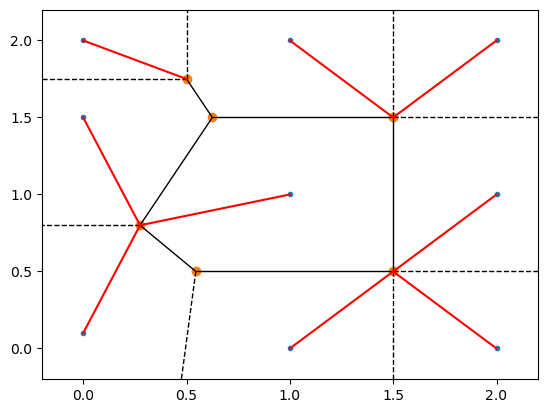

In [29]:
import numpy as np
points = np.array([[0, 0.1], [0, 1.5], [0, 2], [1, 0], [1, 1], [1, 2],
                   [2, 0], [2, 1], [2, 2]])
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(points,furthest_site=False)

fig = voronoi_plot_2d(vor)
dists = []

for i,point in enumerate(points):

    # get nearby vertices
    ridges = np.where(vor.ridge_points == i)[0]
    vertex_set = set(np.array(vor.ridge_vertices)[ridges, :].ravel())
    region = [x for x in vor.regions if set(x) == vertex_set][0]
    region = [x for x in region if x != -1] # remove outliers
    polygon = vor.vertices[region]
    if len(polygon) < 1:
        continue

    # calc distance of every vertex to the initial point
    distances = distance.cdist([point], polygon).T
    max_dist_idx = np.argmax(distances)
    max_dist = distances[max_dist_idx]
    dists.append(max_dist)

    # just for visuals
    xvals = [point[0], polygon[max_dist_idx][0]]
    yvals = [point[1], polygon[max_dist_idx][1]]
    plt.plot(xvals,yvals,'r-')
    # do stuff with that info

plt.show()

Punto [0.  0.1] distancia máxima: 0.7520804478245663
Punto [0.  1.5] distancia máxima: 0.7520804478245662
Punto [0. 2.] distancia máxima: 0.5590169943749475
Punto [1. 0.] distancia máxima: 0.7071067811865476
Punto [1. 1.] distancia máxima: 0.7520804478245661
Punto [1. 2.] distancia máxima: 0.7071067811865476
Punto [2. 0.] distancia máxima: 0.7071067811865476
Punto [2. 1.] distancia máxima: 0.7071067811865476
Punto [2. 2.] distancia máxima: 0.7071067811865476


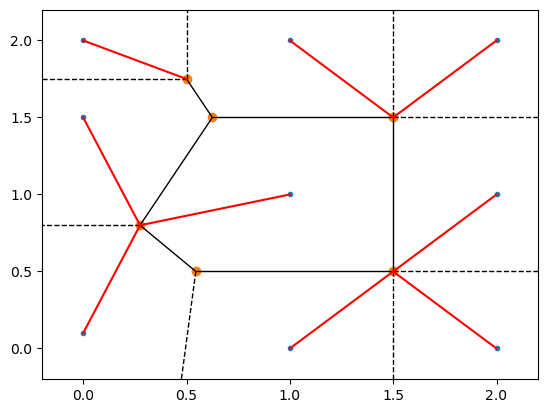

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial.distance import cdist

points = np.array([[0, 0.1], [0, 1.5], [0, 2], [1, 0], [1, 1], [1, 2],
                   [2, 0], [2, 1], [2, 2]])

vor = Voronoi(points, furthest_site=False)

fig = voronoi_plot_2d(vor)
dists = []

for i, point in enumerate(points):

    # get nearby vertices
    ridges = np.where(vor.ridge_points == i)[0]
    vertex_set = set(np.array(vor.ridge_vertices)[ridges, :].ravel())
    region = [x for x in vor.regions if set(x) == vertex_set][0]
    region = [x for x in region if x != -1]  # remove outliers
    polygon = vor.vertices[region]
    if len(polygon) < 1:
        continue

    # calc distance of every vertex to the initial point
    distances = cdist([point], polygon).T
    max_dist_idx = np.argmax(distances)
    max_dist = distances[max_dist_idx][0]  # Extract the scalar value
    dists.append(max_dist)

    # just for visuals
    xvals = [point[0], polygon[max_dist_idx][0]]
    yvals = [point[1], polygon[max_dist_idx][1]]
    plt.plot(xvals, yvals, 'r-')

    # Print distance information
    print(f'Punto {point} distancia máxima: {max_dist}')

plt.show()


Punto [0.  0.1] distancia máxima: 0.7520804478245663, radio: 0.2105894862071196
Punto [0.  1.5] distancia máxima: 0.7520804478245662, radio: 0.4777868143457757
Punto [0. 2.] distancia máxima: 0.5590169943749475, radio: 0.31851268875853206
Punto [1. 0.] distancia máxima: 0.7071067811865476, radio: 0.9854635118546027
Punto [1. 1.] distancia máxima: 0.7520804478245661, radio: 0.5826962456319904
Punto [1. 2.] distancia máxima: 0.7071067811865476, radio: 0.5979130923989302
Punto [2. 0.] distancia máxima: 0.7071067811865476, radio: 0.7115780131189788
Punto [2. 1.] distancia máxima: 0.7071067811865476, radio: 0.49486768490369404
Punto [2. 2.] distancia máxima: 0.7071067811865476, radio: 0.3095202173484792
El espacio no está relleno.


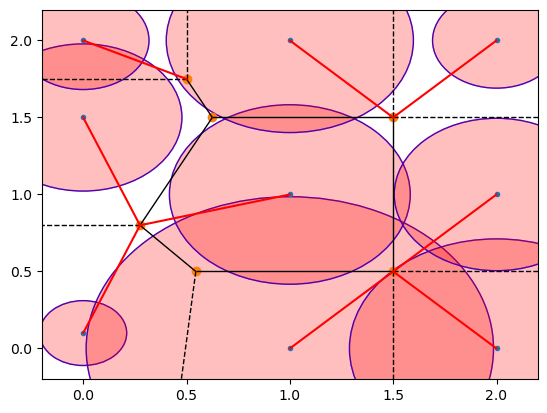

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial.distance import cdist

points = np.array([[0, 0.1], [0, 1.5], [0, 2], [1, 0], [1, 1], [1, 2],
                   [2, 0], [2, 1], [2, 2]])

vor = Voronoi(points, furthest_site=False)

fig, ax = plt.subplots()
voronoi_plot_2d(vor, ax=ax)
dists = []

max_distances = []  # To track the maximum distance for each point
radius_tot = []
for i, point in enumerate(points):

    # Generate a random radius between 0 and 0.5
    radius = np.random.uniform(0.2, 1)
    radius_tot.append(radius)

    # Update the maximum distance
    distances = cdist([point], vor.vertices).T
    max_dist = np.max(distances)
    max_distances.append(max_dist)

    # Plot a circle around the point with the chosen radius
    circle = Circle((point[0], point[1]), radius, color='blue', fill=False)
    ax.add_patch(circle)

    # Fill the interior of the circle in red with alpha 0.25
    circle_fill = Circle((point[0], point[1]), radius, color='red', alpha=0.25)
    ax.add_patch(circle_fill)

    # get nearby vertices
    ridges = np.where(vor.ridge_points == i)[0]
    vertex_set = set(np.array(vor.ridge_vertices)[ridges, :].ravel())
    region = [x for x in vor.regions if set(x) == vertex_set][0]
    region = [x for x in region if x != -1]  # remove outliers
    polygon = vor.vertices[region]
    if len(polygon) < 1:
        continue

    # calc distance of every vertex to the initial point
    distances = cdist([point], polygon).T
    max_dist_idx = np.argmax(distances)
    max_dist = distances[max_dist_idx][0]  # Extract the scalar value
    dists.append(max_dist)

    # just for visuals
    xvals = [point[0], polygon[max_dist_idx][0]]
    yvals = [point[1], polygon[max_dist_idx][1]]
    plt.plot(xvals, yvals, 'r-')

    # Print distance and radius information
    print(f'Punto {point} distancia máxima: {max_dist}, radio: {radius}')

# Check if all radii are greater than their respective distances
if all(radius > dist for radius, dist in zip(radius_tot, dists)):
    print("El espacio está relleno.")
else:
    print("El espacio no está relleno.")

plt.show()

